# Project 3 - Reddit.com Web APIs & Classification

# Problem Statement

In this project, we are a group of analysts working in an investment advisory firm serving equity market investors. The advisory services are broadly focused on the domains of Value Investing (long-term) and Trend-based Investing (short-medium term). The firm's marketeers have been trolling two subreddits (`r/ValueInvesting` and `r/technicalanalysis`) from reddit.com in the past few years to identify authors who may be inclined towards either of these domains in order to offer targeted marketing to them. A database was maintained over years containing respective author's posted contents, which subreddit it came from, date/time along with other information.

Recently, a new marketing intern accidentally deleted the subreddit's database. Although most data were salvaged, the subreddit's source column amongst other lost data was not retrievable. The source column was critical to marketing team's effort in delivering appropriate marketing materials to the authors according to their investment inclination. The only way to retrieve that information was to try scrapping the subreddits for all contents. This is not possible as the duration was too dated too far back, reddit.com only allow around 1200 posts to be scrapped at any one time and it will take a very long time to sort thru the data. Moreover, the two subreddits were highly correlated in words used that made it even harder for the marketing team to manually decipher in a short time.

The furious firm's Marketing Director requested that the analyst team **find a way to process the salvaged data and re-classify them as accurately as possible into the respective subreddits.**

The analyst team found this to be a binary classification problem. The data to train and evaluate the model could be scrapped using reddit.com's JSON API. We can use a Natural Language Processor to train a classifier model to predict from which subreddit a given post came from.  Armed with this information, the team proceeded with obtaining the data and building the classification model.

**The overall success of the prediction model shall be based upon its Accuracy and a balance of other metrics like Sensitivity, Specificity and Precision.**

# Data source

We wrote a series of codes that loop thru reddit.com json API for the two subreddits to extract the recent posts information. These data were then stored as CSV files and re-imported here for processing. The codes file can be found in the datasets directory as `get_data.ipynb`. As those codes can take a while to run, we did not include them here.

# Importing packages

In [1]:
# standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

# nltk packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# scikit learn packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Word Cloud packages
from wordcloud import WordCloud
from PIL import Image

# setting some parameters
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

# Data collection and importing

Data was collected using a custom function that can be found in this file ["get_data.ipynb"](get_data.ipynb). The function sent repeated requests to reddit.com and obtained 25 posts each run, running for 50 times with a random pause timer between 2 to 6 seconds.

The pulled data were converted into a pandas dataframe and with each run of 25 extracted posts, the dataframe was saved to a CSV file to prevent losing extracted data should anything goes wrong in the 50 loops. This process was repeated for both subreddits.

Here, we read in the extracted data CSV files for further processing.

In [2]:
data1 = pd.read_csv("datasets/technicalanalysis.csv")
data2 = pd.read_csv("datasets/valueinvesting.csv")
# concat the two df
all_data_df = pd.concat([data1, data2])
all_data_df.reindex()
print(all_data_df.shape)
all_data_df.head()

(2488, 115)


approved_at_utc          subreddit  \
0              NaN  technicalanalysis   
1              NaN  technicalanalysis   
2              NaN  technicalanalysis   
3              NaN  technicalanalysis   
4              NaN  technicalanalysis   

                                            selftext author_fullname  saved  \
0  [https://i.ibb.co/2jXq0jV/lines.png](https://i...     t2_1584s3r7  False   
1  Those are the greatest questions of all.  \n\n...     t2_1584s3r7  False   
2  Hi!\n\nI am a total beginner and cant really a...        t2_x3zul  False   
3  isn't 3-5-B an head&amp;shoulder? why it didn'...     t2_1584s3r7  False   
4                                                NaN     t2_2155qzgo  False   

   mod_reason_title  gilded  clicked  \
0               NaN       0    False   
1               NaN       0    False   
2               NaN       0    False   
3               NaN       0    False   
4               NaN       0    False   

                                               title link_flair_richtext  \
0                              What are those lines?                  []   
1  the price goes to a top---&gt;ok, when to sell...                  []   
2                          Best places to learn from                  []   
3                                  head&amp;shoulder                  []   
4                      Engulfing Candlestick Pattern                  []   

  subreddit_name_prefixed  hidden  pwls  link_flair_css_class  downs  \
0     r/technicalanalysis   False     6                   NaN      0   
1     r/technicalanalysis   False     6                   NaN      0   
2     r/technicalanalysis   False     6                   NaN      0   
3     r/technicalanalysis   False     6                   NaN      0   
4     r/technicalanalysis   False     6                   NaN      0   

   thumbnail_height  top_awarded_type  hide_score       name  quarantine  \
0               NaN               NaN       False  t3_k2vung       False   
1               NaN               NaN       False  t3_k28uze       False   
2               NaN               NaN       False  t3_k216ip       False   
3               NaN               NaN       False  t3_k1s7eb       False   
4              75.0               NaN       False  t3_k1flir       False   

  link_flair_text_color  upvote_ratio  author_flair_background_color  \
0                  dark          0.86                            NaN   
1                  dark          0.86                            NaN   
2                  dark          1.00                            NaN   
3                  dark          1.00                            NaN   
4                  dark          1.00                            NaN   

  subreddit_type  ups  total_awards_received media_embed  thumbnail_width  \
0         public    5                      0          {}              NaN   
1         public    5                      0          {}              NaN   
2         public    6                      0          {}              NaN   
3         public    3                      0          {}              NaN   
4         public   26                      0          {}            140.0   

   author_flair_template_id  is_original_content user_reports secure_media  \
0                       NaN                False           []          NaN   
1                       NaN                False           []          NaN   
2                       NaN                False           []          NaN   
3                       NaN                False           []          NaN   
4                       NaN                False           []          NaN   

   is_reddit_media_domain  is_meta  category secure_media_embed  \
0                   False    False       NaN                 {}   
1                   False    False       NaN                 {}   
2                   False    False       NaN                 {}   
3                   False    False       NaN                

# Data dictionary

There was no standard data dictionary available for this project other than the raw data structure and intuitive understanding of how reddit.com structured their website. From the JSON API, a total of 115 features columns were extracted from each subreddit data pull, with a row level record range of around 1200 posts before reddit.com API starts rejecting data requests. Out of the 115 columns, we only required 5 columns namely `subreddit`, `selftext`, `title`, `author` and `created_utc` columns. We documented our own data dictionary as follows:

| Feature | Description | Datatype | Range | Example |
|:-|:-|:-|:-|:-|
| subreddit | name of the subreddit | string | undefined | "ValueInvesting" "technicalanalysis" |
| selftext | sentences made by the author | string | undefined | "Benjamin Graham often spoke about the importance of bonds in an intelligent portfolio" |
| title | title of the post | string | undefined | "Research on price movements due to large investors" |
| author | name of the author | string | undefined | "tropicalcoconut29" |
| created_utc | date and time of post creation in UTC format | string | varies | "1606597322" |

In [3]:
# extract only the columns require
data_df = all_data_df[['subreddit', 'selftext', 'title', 'author', 'created_utc']]
data_df.head()

subreddit                                           selftext  \
0  technicalanalysis  [https://i.ibb.co/2jXq0jV/lines.png](https://i...   
1  technicalanalysis  Those are the greatest questions of all.  \n\n...   
2  technicalanalysis  Hi!\n\nI am a total beginner and cant really a...   
3  technicalanalysis  isn't 3-5-B an head&amp;shoulder? why it didn'...   
4  technicalanalysis                                                NaN   

                                               title         author  \
0                              What are those lines?        luchins   
1  the price goes to a top---&gt;ok, when to sell...        luchins   
2                          Best places to learn from    CaptainDrug   
3                                  head&amp;shoulder        luchins   
4                      Engulfing Candlestick Pattern  SoheilPakpour   

    created_utc  
0  1.606598e+09  
1  1.606508e+09  
2  1.606484e+09  
3  1.606442e+09  
4  1.606399e+09

# Data cleaning

**Removing duplicated posts**

Re-posting was common in reddit.com and this resulted in duplicated records in our data. To remove the duplicates, we ran the following codes to keep only one of the duplicated posts. As a result, our dataset records drop from 2488 to 1844 rows.

In [4]:
# Removing duplicated posts
data_df.drop_duplicates(subset='title', keep='last', inplace=True)
data_df.reset_index(drop=True, inplace=True)
print(data_df.shape)
data_df.sample(frac=1).head(5)

(1844, 5)


<ipython-input-4-60bb4ee3f631>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop_duplicates(subset='title', keep='last', inplace=True)


subreddit                                           selftext  \
1079     ValueInvesting                                                NaN   
485   technicalanalysis  [https://i.ibb.co/2jXq0jV/lines.png](https://i...   
402   technicalanalysis  i have data feed to DTNIQ /amibroker/ninjatrad...   
1200     ValueInvesting  Does anyone have a copy (pdf) of this book.......   
203   technicalanalysis                                                NaN   

                                                  title            author  \
1079                  The Rise, Fall and Revival of AMD  investorinvestor   
485                               What are those lines?           luchins   
402                        custom charting and analysis         junkone11   
1200                                        PDF request           Agubm12   
203   Is ETHEREUM breaking out ? | ALT SEASON starte...         Etherpong   

       created_utc  
1079  1.596004e+09  
485   1.606598e+09  
402   1.536169e+09  
1200  1.592986e+09  
203   1.570623e+09

**Dealing with NaN**

Null values were identified and imputed with "---" which will be taken care of later.

In [5]:
# check for null, only selftext have nulls which is okay cos it will be combined with title
data_df.isnull().sum()

subreddit        0
selftext       846
title            0
author           0
created_utc      0
dtype: int64

In [6]:
# impute NaN in selftext with '---'
data_df.fillna('---', axis=0, inplace=True)
data_df.isnull().sum()

C:\Users\scbje\anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


subreddit      0
selftext       0
title          0
author         0
created_utc    0
dtype: int64

**Dealing with data types**

`created_utc` was in the incorrect format so we converted it using pandas to_datetime method.

In [7]:
# datatype check - notice that the created_utc is not in the correct type
data_df.dtypes

subreddit       object
selftext        object
title           object
author          object
created_utc    float64
dtype: object

In [8]:
# converting to the correct datetime
data_df['created_utc'] = pd.to_datetime(data_df['created_utc'],unit='s')
data_df.head()

<ipython-input-8-de79efa092d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['created_utc'] = pd.to_datetime(data_df['created_utc'],unit='s')


subreddit                                           selftext  \
0  technicalanalysis  I found a Jeff Tompkins course through a Udemy...   
1  technicalanalysis   \n\n## dow jones analysis 20 April\n\n#### Al...   
2  technicalanalysis                                                ---   
3  technicalanalysis                                                ---   
4  technicalanalysis                                                ---   

                                               title           author  \
0  TradeTrend - Jeff Tompkins does anyone have an...  AlternativeHole   
1                        dow jones analysis 20 April           selawy   
2                         Something to look out for.        JasonA121   
3                 GBP/USD is Forming a Rising Wedge!         hroob777   
4        USD/JPY is Trading in a Descending Triangle         hroob777   

          created_utc  
0 2020-04-20 20:44:23  
1 2020-04-20 12:47:52  
2 2020-04-20 09:28:15  
3 2020-04-19 20:15:39  
4 2020-04-19 16:59:11

**Preparing text string**

We combined the `selftext` and `title` columns to ensure that we have maximum words opportunity to evaluate in the later steps while at the same time keeping the number of records intact instead of dropping the rows with NaN values (imputed with "---" in earlier step). This was sort of a feature engineering with the new collumn named `unclean_text`.

In [9]:
# combining title and selftext
data_df['unclean_text'] = data_df.loc[:,'title'] + '' + data_df.loc[:,'selftext']
data_df.drop(['title', 'selftext'], axis=1, inplace=True)
data_df.head()

<ipython-input-9-16d11c754b08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['unclean_text'] = data_df.loc[:,'title'] + '' + data_df.loc[:,'selftext']
C:\Users\scbje\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


subreddit           author         created_utc  \
0  technicalanalysis  AlternativeHole 2020-04-20 20:44:23   
1  technicalanalysis           selawy 2020-04-20 12:47:52   
2  technicalanalysis        JasonA121 2020-04-20 09:28:15   
3  technicalanalysis         hroob777 2020-04-19 20:15:39   
4  technicalanalysis         hroob777 2020-04-19 16:59:11   

                                        unclean_text  
0  TradeTrend - Jeff Tompkins does anyone have an...  
1  dow jones analysis 20 April \n\n## dow jones a...  
2                      Something to look out for.---  
3              GBP/USD is Forming a Rising Wedge!---  
4     USD/JPY is Trading in a Descending Triangle---

In [10]:
# check for subreddit strings
data_df['subreddit'].unique()

array(['technicalanalysis', 'ValueInvesting'], dtype=object)

In [11]:
# lowercase the strings to standardize
data_df['subreddit'] = data_df['subreddit'].str.lower()
data_df['subreddit'].unique()

<ipython-input-11-eb5332e4392a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['subreddit'] = data_df['subreddit'].str.lower()


array(['technicalanalysis', 'valueinvesting'], dtype=object)

**Mapping the classes**

We mapped the subreddits accordingly since this was a binary classification problem.

In [12]:
# create a column subreddit_class that represents a subreddit as a binary value 0 or 1
# 1 for 'valueinvesting' and 0 for 'technicalanalysis since problem statement
# is interested to class for 'valueinvesting'
data_df['subreddit_class'] = [1 if i == 'valueinvesting' else 0 for i in data_df['subreddit']]
data_df.sample(frac=1).head()

<ipython-input-12-421cf07125ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['subreddit_class'] = [1 if i == 'valueinvesting' else 0 for i in data_df['subreddit']]


subreddit     author         created_utc  \
1232     valueinvesting  codyehret 2020-06-15 02:12:11   
367   technicalanalysis    mototol 2018-11-17 09:31:10   
1071     valueinvesting  davide838 2020-07-31 09:29:18   
1207     valueinvesting     zikka1 2020-06-21 21:07:22   
817   technicalanalysis    luchins 2020-05-05 13:52:23   

                                           unclean_text  subreddit_class  
1232  HDSN - Refrigeration Re-claimerLet me know wha...                1  
367   What is this structure called?Hi, I'm quite ne...                0  
1071  Does someone know newsletter for value investo...                1  
1207  Book: value trapsAnyone have a pdf of this boo...                1  
817   Could you help me with this image (breack out ...                0

In [13]:
# confirm mapping is done correctly
data_df.subreddit_class.unique()

array([0, 1], dtype=int64)

In [14]:
data_df.sample(frac=1).head()

subreddit             author         created_utc  \
1034     valueinvesting   InfiniteValueptr 2020-08-10 12:28:01   
357   technicalanalysis      LoneRhino1019 2018-12-24 13:51:16   
94    technicalanalysis  SocraticExistence 2020-02-24 16:46:56   
1679     valueinvesting  DeepDataInvesting 2020-11-09 23:18:45   
1556     valueinvesting            SovArya 2020-03-11 08:57:27   

                                           unclean_text  subreddit_class  
1034  Deep dive into the technological aspects of In...                1  
357   Question about head and shoulder patternIs the...                0  
94    What is this pattern and what is happening in ...                0  
1679  Vertical Analysis TutorialHello all! I decided...                1  
1556  Recalling the old school graham growth formula...                1

# Exploratory Data Analysis (EDA)

Next we performed EDA on our data for sanity checks as well as to better understand our data.

## Length of posts

Minimum length:  15
Maximum length:  22132


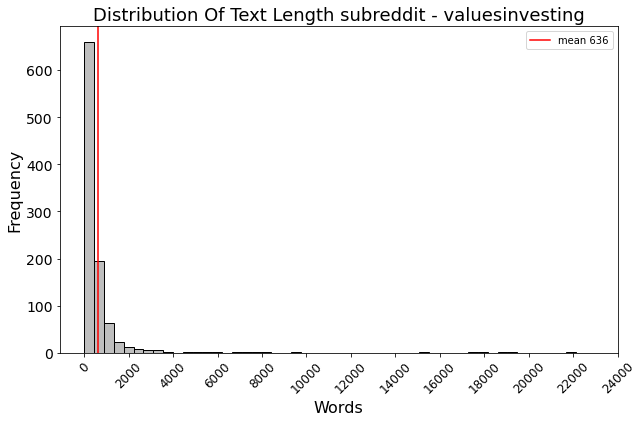

In [15]:
# Generating a list of text lengths
lengths = [len(text) for text in data_df['unclean_text'][data_df['subreddit_class']==1]]
print('Minimum length: ', min(lengths))
print('Maximum length: ', max(lengths))
# Plotting the text lengths
plt.figure(figsize = (10,6), facecolor='white')
sns.histplot(lengths, kde = False, bins = 50, color = "darkgrey")
plt.axvline(np.mean(lengths), color = "red", label="mean "+str(round(np.mean(lengths))))
plt.legend()
plt.title("Distribution Of Text Length subreddit - valuesinvesting", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,25000,2000), size = 12, rotation=45)
plt.yticks(size = 14);
# The red line marks the mean length

**Observation**

We observed that the length of posts from subreddit `valueinvesting` ranges from 15 to 22132 words. Most of the posts length were less than the mean length of 636 words, this was good as that it gave us a higher number of words per post to use for classification. However, there were a number of posts that were extremely long (more than 4,000 words) which meant that there could be a lot of repetitive words. However, we did not see the need to remove these long posts since more words would actually provide more clues for the model to predict.

Minimum length:  7
Maximum length:  4871


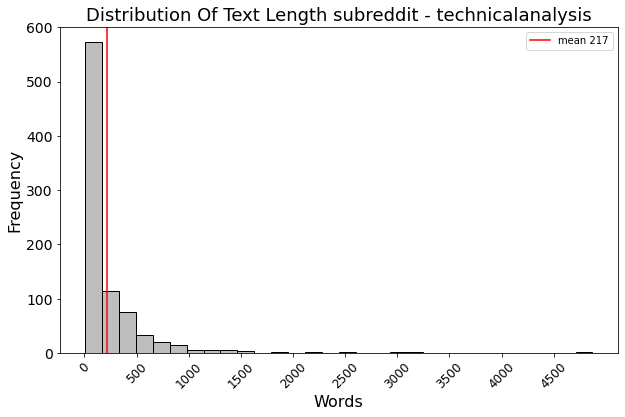

In [16]:
# Generating a list of text lengths
lengths = [len(text) for text in data_df['unclean_text'][data_df['subreddit_class']==0]]
print('Minimum length: ', min(lengths))
print('Maximum length: ', max(lengths))
# Plotting the text lengths
plt.figure(figsize = (10,6), facecolor="white")
sns.histplot(lengths, kde = False, bins = 30, color = "darkgrey")
plt.axvline(np.mean(lengths), color = "red", label="mean "+str(round(np.mean(lengths))))
plt.legend()
plt.title("Distribution Of Text Length subreddit - technicalanalysis", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,5000,500), size = 12, rotation=45)
plt.yticks(size = 14);
# The red line marks the mean length

**Observation**

We observed that the length of posts from subreddit `technicalanalysis` ranges from 7 to 4871 words, considerably shorter than `valueinvesting`. Most of the posts length were less than the mean length of 217 words. Although this was shorter than `valueinvesting`, it was still considered as a good enough number to use for classification. We did not observed any excessively long post like `valueinvesting`, the long posts here were around 500 to 4871 words.

## Lifespan of posts

Here we wanted to establish the periods of the posts that were massively gathered through the JSON API codes. Since the model was expected to re-classify salvaged data dating years back, it would be more appropriate to train a model with a reasonable spread of data lifespan. e.g. within the recent two years.

In [17]:
print(data_df.groupby('subreddit').created_utc.min(),'\n')
print(data_df.groupby('subreddit').created_utc.max())

subreddit
technicalanalysis   2018-05-23 13:52:56
valueinvesting      2020-02-20 15:27:53
Name: created_utc, dtype: datetime64[ns] 

subreddit
technicalanalysis   2020-11-28 21:15:45
valueinvesting      2020-11-28 23:11:35
Name: created_utc, dtype: datetime64[ns]


**Observation**

From the above, we could see that subreddit `technicalanalysis` had post between 2018-05-23 to 2020-11-28 whereas `valueinvesting` had post between 2020-02-20 to 2020-11-28. This means that from the data extracted, there was a good spread of lifespan that suit our analysis purpose.

## Top authors in the subreddits

Here we wanted to identify the top authors in each subreddit so as to be able to target them with the appropriate marketing materials. The inference here was that a frequent author in either of the subreddits was more likely to be interested in services related to that subreddit. The analyst team felt that this information could be the icing on the cake for the Marketing Team.

e.g. A frequent author in value investing is more like to be interested in marketing materials talking about how to value a company.

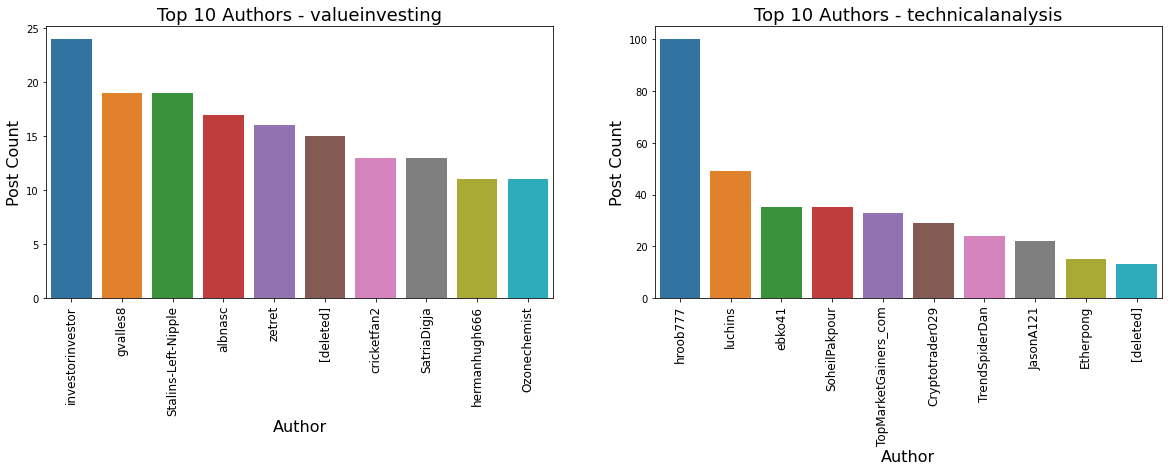

In [18]:
# put into a df for easy plotting
author_valueinvesting = data_df[data_df['subreddit']=='valueinvesting']['author'].value_counts().head(10)
author_technicalanalysis = data_df[data_df['subreddit']=='technicalanalysis']['author'].value_counts().head(10)

# Plotting the most frequent authors
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
#author_valueinvesting.plot.bar()
sns.barplot(x=author_valueinvesting.index, y=author_valueinvesting, ax=ax1)
ax1.set_title("Top 10 Authors - valueinvesting", fontsize=18)
ax1.set_ylabel("Post Count", fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)
ax1.set_xlabel("Author", fontsize=16)

sns.barplot(x=author_technicalanalysis.index, y=author_technicalanalysis, ax=ax2)
ax2.set_title("Top 10 Authors - technicalanalysis", fontsize=18)
ax2.set_ylabel("Post Count", fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize=12)
ax2.set_xlabel("Author", fontsize=16)

plt.show()

**Observation**

We observed that the top 10 authors in `technicalanalysis` subreddit were more active with a higher number of posts. They appeared to be separate group of authors with none frequently posting in both subreddits.

## Custom stop words and Top words

It was important that our model can distinguish relevant words and common words to ensure it's accuracy. Here, we assembled a custom stopwords list by taking the stopwords from nltk corpus, sklearn's stopwords and adding to it the words directly linked to the two subreddits as it would be an easy clue for the model to classify. Thereafter, we extracted the top 20 count words to help determine if we need to revised the custom stopwords list or not.

**Creating a custom stopwords list**

In [19]:
# downloading the default nlth stopwords
nltk.download("stopwords")

# taking nltk stopwords
word1 = stopwords.words('english')

# taking sklearn's stopwords
word2 = list(CountVectorizer(stop_words = 'english').get_stop_words())

# words from the subreddits title themselves
word3 = ['value', 'investing', 'technical', 'analysis']

# make custom stopword
custom_stopwords = word1+word2+word3
len(custom_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\scbje\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


501

**Top words using basic vectorized count**

We performed basic vectorizing to the `unclean text` to extract the top 20 most common words used in both subreddits so we could built a custom stop word list that would help to exclude obvious words from the model that could skew the result.

In [20]:
# Instantiating the vectorizer and masking the vectorizer with custom stop words
cvec_valueinvesting = CountVectorizer(stop_words = custom_stopwords)
cvec_technicalanalysis = CountVectorizer(stop_words = custom_stopwords)

# Subsetting the dataframe
valueinvesting_df = data_df[data_df['subreddit_class'] == 1]
technicalanalysis_df = data_df[data_df['subreddit_class'] == 0]

# Fit-transforming the vectorizer
vec_valueinvesting = cvec_valueinvesting.fit_transform(valueinvesting_df['unclean_text'])
vec_technicalanalysis = cvec_technicalanalysis.fit_transform(technicalanalysis_df['unclean_text'])

In [21]:
# Saving the vectorized dfs to a new dataframe
vec_valueinvesting_df = pd.DataFrame(vec_valueinvesting.toarray(),
                                         columns = cvec_valueinvesting.get_feature_names())
vec_technicalanalysis_df = pd.DataFrame(vec_technicalanalysis.toarray(),
                                            columns = cvec_technicalanalysis.get_feature_names())

# Getting the 20 most frequent words from each subreddit
value_top20_df = pd.DataFrame(vec_valueinvesting_df.sum().sort_values(ascending = False).head(20))
technical_top20_df = pd.DataFrame(vec_technicalanalysis_df.sum().sort_values(ascending = False).head(20))

In [22]:
# function to plot
def plot_most_frequent_words(dataframes, titles):
    # The count inidcates where in the subplot to go
    count = 0
    fig = plt.figure(figsize = (20,14), facecolor = "white")    
    # Enumerating allows for the list of titles to be referenced
    for d, dataframe in enumerate(dataframes):
        # Updating the location
        count += 1
        ax = fig.add_subplot(2, 2, count)        
        # Creating the graph
        sns.barplot(x = 0, y = dataframe.index, data = dataframe, palette = "deep")        
        # Setting the graph parameters
        plt.title(f"Most Common Words From {titles[d]}", size = 16)
        plt.xlabel("Number Of Occurences", size = 14)
        plt.xticks(size = 14)
        plt.yticks(size = 14)

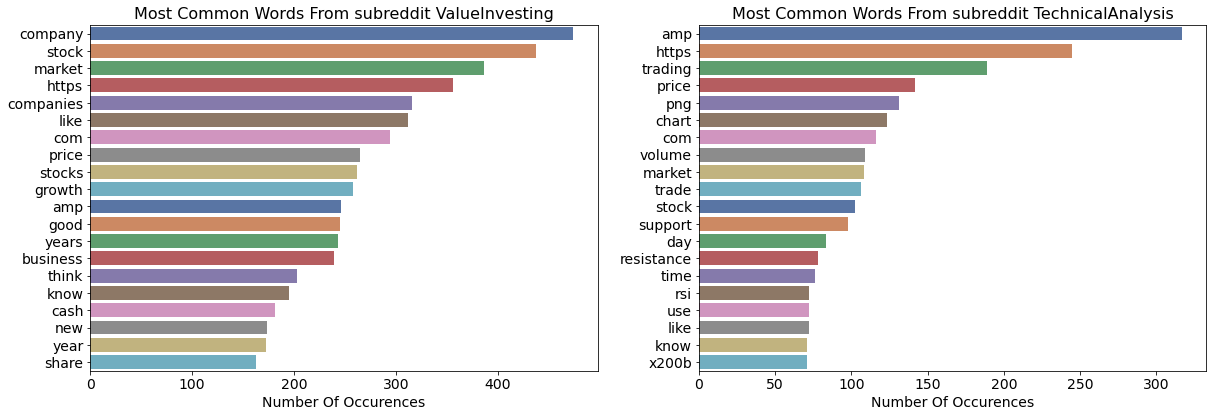

In [23]:
# Plotting the most common words
plot_most_frequent_words(dataframes = [value_top20_df, 
                                       technical_top20_df],
                         titles     = ['subreddit ValueInvesting', 
                                       'subreddit TechnicalAnalysis'])

**Observation**

We could see that there were many words that occurred in both subreddits such as 'https', 'market'. Furthermore, we noticed that we must lemmatize or stem the text columns because there were multiple forms of words in the most frequent words such as 'stock'-'stocks' and 'company'-'companies'. There were also words that did not make sense such as 'amp' and 'x200b'. Thus, we decided to update the custom stopwords list with some of these words.

In [24]:
# adding more words from top 20 common words from both subreddits to custom stopwords list
word4 = ['companies', 'stocks', 'markets', 'https', 'like', 'com', 'amp', 'years', 'think',
         'know', 'new', 'share', 'png', 'use', 'x200b']

# update custom_stopwords
custom_stopwords.extend(word4)
len(custom_stopwords)

516

In [25]:
# to get a sense of how many features to consider on modeling later
print(vec_valueinvesting.shape)
print(vec_technicalanalysis.shape)

(989, 8689)
(855, 4006)


## Words Cloud

Words Cloud can helped us quickly and easily visualized the common words in both and each subreddits.

In [26]:
# define a function to tokenize any string pass to it
def tok_text(text):
    tokenizer = RegexpTokenizer(r'\w+') # regex is filtering only the words, excluding punctuations
    text_token = tokenizer.tokenize(text.lower())
    # all strings were converted to lower case
    # all punctuation was removed (This was done using regular expressions)
    return text_token

# apply the function to the dataframe of unclean_text
data_df['tok_text'] = data_df['unclean_text'].apply(tok_text)
all_text = " ".join([" ".join(text) for text in data_df['tok_text']])
value_text = " ".join([" ".join(text) for text in data_df['tok_text'][data_df['subreddit_class']==1]])
technical_text = " ".join([" ".join(text) for text in data_df['tok_text'][data_df['subreddit_class']==0]])

<ipython-input-26-e795453f9128>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['tok_text'] = data_df['unclean_text'].apply(tok_text)


In [27]:
# define a function to tokenize any string pass to it
def tok_text(text):
    tokenizer = RegexpTokenizer(r'\w+') # regex is filtering only the words, excluding punctuations
    text_token = tokenizer.tokenize(text.lower())
    # all strings were converted to lower case
    # all punctuation was removed (This was done using regular expressions)
    return text_token

# apply the function to the dataframe of unclean_text
data_df['tok_text'] = data_df['unclean_text'].apply(tok_text)

# to generate the list of words used in the wordcloud function
all_text = " ".join([" ".join(text) for text in data_df['tok_text']])
value_text = " ".join([" ".join(text) for text in data_df['tok_text'][data_df['subreddit_class']==1]])
technical_text = " ".join([" ".join(text) for text in data_df['tok_text'][data_df['subreddit_class']==0]])

<ipython-input-27-85f7a4facb2f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['tok_text'] = data_df['unclean_text'].apply(tok_text)


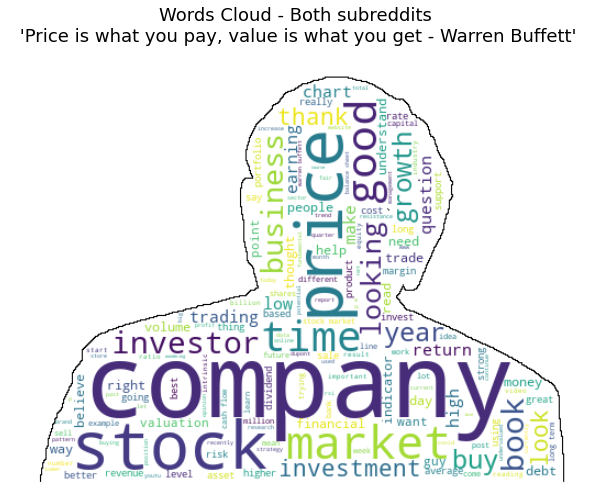

In [28]:
# wordcloud for both reddits together
# image with warren shape
warren_mask_image = np.array(Image.open('images/warren.png'))

wordcloud = WordCloud(max_font_size=100, max_words=150,
                      background_color="white",
                      stopwords = custom_stopwords, #note using custom_stopwords
                      contour_width=0.1,
                      contour_color='black',
                      width=800, height=400,
                      mask=warren_mask_image).generate(all_text)

fig = plt.subplots(1,1, figsize=(12,8), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words Cloud - Both subreddits\n '"'Price is what you pay, value is what you get - Warren Buffett'"'',
          fontsize=18)
plt.show()

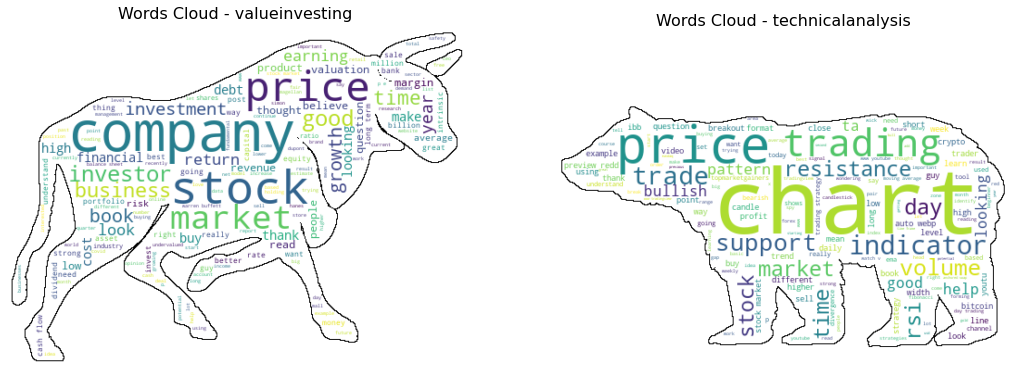

In [29]:
# wordcloud for valueinvesting and technicalanalysis side by side
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,10), facecolor="white")

# image with bull shape
value_mask_image = np.array(Image.open('images/bull.png'))

wordcloud = WordCloud(max_font_size=100, max_words=150,
                      background_color="white",
                      stopwords = custom_stopwords, #note using custom_stopwords
                      contour_width=0.1,
                      contour_color='black',
                      mask=value_mask_image).generate(value_text)
ax1.imshow(wordcloud, interpolation="bilinear");
ax1.axis("off");
ax1.set_title("Words Cloud - valueinvesting", fontsize=16)


# image with bear shape
technical_mask_image = np.array(Image.open('images/bear.png'))

wordcloud = WordCloud(max_font_size=100, max_words=150,
                      background_color="white",
                      stopwords = custom_stopwords, #note using custom_stopwords
                      contour_width=0.1,
                      contour_color='black',
                      mask=technical_mask_image).generate(technical_text)
ax2.imshow(wordcloud, interpolation="bilinear");
ax2.axis("off");
ax2.set_title("Words Cloud - technicalanalysis", fontsize=16)
plt.show();

**Observation**

From the word clouds, we noticed that there were many common words between the subreddits that could make it hard to classify them correctly. **Thus, a customized stopwords list was definitely necessary** but not to the point where it becomes too hard to differentiate the subreddits. There were other parameters that could be used to tune this heuristic.

# Pre-processing

## Tokenize and Lemmatizing or Stemming

When we "tokenize" data, we take it and split it up into distinct chunks based on some pattern filtered by RegEx.

Lemmatizing is usually the more correct and precise way of handling things from a grammatical point of view, but also might not have much of an effect.

When we "stem" data, we take words and attempt to return a base form of the word. It tends to be cruder than using lemmatization.

In simple words, stemming technique only looks at the form of the word whereas lemmatization technique looks at the meaning of the word. It means after applying lemmatization, we will always get a valid word.

We explored which would be a better preparation method to use for our case.

In [30]:
data_df.sample(frac=1).head()

subreddit         author         created_utc  \
602   technicalanalysis     seohiroth7 2020-09-09 11:58:35   
1285     valueinvesting   sammindlin26 2020-06-01 19:36:35   
356   technicalanalysis  swagmonster55 2018-12-25 17:42:54   
174   technicalanalysis      Etherpong 2019-10-28 23:06:59   
152   technicalanalysis       Lampooka 2019-11-25 22:30:07   

                                           unclean_text  subreddit_class  \
602   I don't really have the patience for books...W...                0   
1285  Industry Primers and Other Research ResourcesI...                1   
356   How to accurately draw trends for bearish and ...                0   
174   Interview with Dutch crypto trader Martijn Hou...                0   
152                                            $AXSM---                0   

                                               tok_text  
602   [i, don, t, really, have, the, patience, for, ...  
1285  [industry, primers, and, other, research, reso...  
356   [how, to, accurately, draw, trends, for, beari...  
174   [interview, with, dutch, crypto, trader, marti...  
152                                              [axsm]

In [31]:
# define a function to stem any string pass to it
def tok_stem_text(text):    
    tokenizer = RegexpTokenizer(r'\w+') # regex is filtering only the words, excluding punctuations
    text_token = tokenizer.tokenize(text.lower())
    # all strings were converted to lower case
    # all punctuation was removed (This was done using regular expressions)
    stemmer = PorterStemmer()
    stem_word = ' '.join(map(lambda x: stemmer.stem(x), text_token))
    if text_token != stem_word:
        print(text_token, '\n')
        print(stem_word, '\n')
    return stem_word

# apply the function to the dataframe of unclean_text
data_df['stemmed_text'] = data_df['unclean_text'].apply(tok_stem_text)

['tradetrend', 'jeff', 'tompkins', 'does', 'anyone', 'have', 'any', 'experience', 'with', 'this', 'package', 'i', 'found', 'a', 'jeff', 'tompkins', 'course', 'through', 'a', 'udemy', 'course', 'on', 'options', 'the', 'course', 'itself', 'seemed', 'informative', 'and', 'legitimate', 'but', 'fwiw', 'i', 'am', 'new', 'to', 'trading', 'an', 'technical', 'analysis', 'so', 'my', 'assessment', 'of', 'his', 'course', 'might', 'not', 'mean', 'much', 'he', 'promotes', 'a', 'software', 'bundle', 'called', 'tradetrend', 'from', 'the', 'sounds', 'of', 'the', 'video', 'pitch', 'it', 'sounds', 'like', 'a', 'tweaked', 'technical', 'indicator', 'that', 'gives', 'obvious', 'buy', 'sell', 'signals', 'and', 'he', 's', 'packaged', 'with', 'training', 'coaches', 'and', 'other', 'content', 'on', 'his', 'site', 'i', 'm', 'absolutely', 'interested', 'in', 'learning', 'more', 'about', 'ta', 'as', 'well', 'and', 'this', 'seemed', 'like', 'a', 'very', 'spoon', 'fed', 'approach', 'to', 'applying', 'ta', 'to', 'my'

chart pattern cheat sheet 

['a', 'different', 'type', 'of', 'technical', 'analysis'] 

a differ type of technic analysi 

['what', 's', 'there', 'best', 'way', 'to', 'save', 'on', 'taxesshould', 'you', 'trade', 'under', 'an', 'llc', 'or', 'open', 'your', 'own', 'home', 'based', 'business', 'not', 'exactly', 'sure', 'which', 'route', 'to', 'go', 'any', 'ideas', 'explanations', 'or', 'any', 'type', 'of', 'insights', 'would', 'be', 'great', 'thank', 'you', 'guys', 'in', 'advance'] 

what s there best way to save on taxesshould you trade under an llc or open your own home base busi not exactli sure which rout to go ani idea explan or ani type of insight would be great thank you guy in advanc 

['looking', 'for', 'a', 'mentor', 'or', 'group', 'to', 'learn', 'with', 'just', 'what', 'the', 'title', 'says', 'if', 'any', 'one', 'would', 'be', 'willing', 'to', 'help', 'me', 'out', 'with', 'learning', 'or', 'a', 'group', 'of', 'new', 'traders', 'to', 'study', 'with', 'i', 'could', 'join', 'would

['where', 'can', 'i', 'see', 'the', 'support', 'power', 'i', 'trade', 'stocks', 'so', 'i', 'have', 'an', 'order', 'book', 'to', 'look', 'at', 'so', 'many', 'times', 'i', 'have', 'red', 'the', 'sentence', 'support', 'is', 'insane', 'at', 'this', 'price', 'level', 'but', 'i', 'don', 't', 'know', 'what', 'does', 'it', 'mean', 'how', 'can', 'someone', 'know', 'that', 'support', 'is', 'strong', 'in', 'a', 'certain', 'price', 'level', 'which', 'indicators', 'will', 'he', 'look', 'at', 'in', 'order', 'to', 'grasp', 'this', 'information', 'what', 'should', 'happen', 'into', 'the', 'order', 'book', 'i', 'have', 'always', 'have', 'red', 'that', 'it', 's', 'pointless', 'to', 'look', 'in', 'the', 'order', 'book', 'cause', 'many', 'buy', 'wall', 'and', 'sell', 'wall', 'are', 'fake', 'so', 'what', 'to', 'do'] 

where can i see the support power i trade stock so i have an order book to look at so mani time i have red the sentenc support is insan at thi price level but i don t know what doe it mean ho


serious emot asid let discuss dropbox i understand tech is overvalu there s is mani compani that are cloud comput is the perfect exampl also there are mani compani not turn a profit dropbox is compar to the recovey that other compani had after covid thi seem like it could be undervalu in it respect sector thi is a profit compani 

['what', 'do', 'these', 'paragraph', 'mean', 'the', 'intelligent', 'investor', 'the', 'u', 's', 'internal', 'revenue', 'code', 'allows', 'you', 'to', 'use', 'your', 'realized', 'losses', 'any', 'declines', 'in', 'value', 'that', 'you', 'lock', 'in', 'by', 'selling', 'your', 'shares', 'to', 'offset', 'up', 'to', '3', '000', 'in', 'ordinary', 'income', 'let', 's', 'say', 'you', 'bought', '200', 'shares', 'of', 'coca', 'cola', 'stock', 'in', 'january', '2000', 'for', '60', 'a', 'share', 'a', 'total', 'investment', 'of', '12', '000', 'by', 'year', 'end', '2002', 'the', 'stock', 'was', 'down', 'to', '44', 'a', 'share', 'or', '8', '800', 'for', 'your', 'lot', 'a',

['career', 'or', 'entrepreneurial', 'opportunities', 'in', 'the', 'investing', 'field', 'hey', 'everyone', 'i', 'm', '24', 'and', 'a', 'lifelong', 'entrepreneur', 'i', 'have', 'never', 'had', 'a', 'real', 'job', 'and', 'since', 'i', 'was', '18', 'i', 've', 'made', 'a', 'living', 'from', 'all', 'sorts', 'of', 'businesses', 'that', 'i', 've', 'started', 'i', 've', 'spent', 'the', 'last', '3', 'years', 'in', 'the', 'marketing', 'agency', 'space', 'i', 'built', 'a', 'large', 'business', 'in', 'the', 'industry', 'that', 'sold', 'to', 'other', 'agency', 's', 'over', '3', 'years', 'i', 'closed', 'it', 'last', 'august', 'and', 'just', 'found', 'myself', 'completely', 'burned', 'out', 'and', 'stressed', 'the', 'bigger', 'the', 'business', 'got', 'and', 'the', 'faster', 'it', 'grew', 'the', 'unhappier', 'i', 'became', 'i', 'm', 'over', 'the', 'desire', 'to', 'build', 'a', 'really', 'big', 'business', 'and', 'get', 'rich', 'that', 'i', 'once', 'had', 'i', 'still', 'love', 'business', 'but', 'i', 


sell you shareswhen you have care assign an intrins valu to a compani and it s approach that price at the moment would you sell when it hit the intrins valu per share or just befor or just after what are your thought on the sell procedur 

['what', 's', 'the', 'difference', 'between', 'free', 'cash', 'flow', 'and', 'earnings', 'they', 'seem', 'to', 'be', 'the', 'same', 'thing', 'at', 'first', 'sight', 'but', 'i', 'm', 'not', 'sure'] 

what s the differ between free cash flow and earn they seem to be the same thing at first sight but i m not sure 

['value', 'investing', 'the', 'definitive', 'guide', 'covers', 'everything', 'from', 'buffets', 'advise', 'to', 'small', 'investors', 'to', 'all', 'the', 'resources', 'you', 'will', 'need', 'to', 'calculate', 'intrinsic', 'value'] 

valu invest the definit guid cover everyth from buffet advis to small investor to all the resourc you will need to calcul intrins valu 

['can', 'someone', 'please', 'share', 'their', 'financial', 'modeling', 'pr

['how', 'do', 'you', 'value', 'a', 'company', 'with', 'rapid', 'gross', 'profit', 'growth', 'but', 'no', 'net', 'income', 'growth', 'i', 'm', 'interesting', 'in', 'investing', 'in', 'oss', 'because', 'it', 'has', 'doubled', 'its', 'gross', 'profits', 'every', 'two', 'years', 'they', 'spend', 'everything', 'they', 'earn', 'each', 'year', 'on', 'r', 'amp', 'd', 'and', 'business', 'expenses', 'so', 'they', 'don', 't', 'report', 'a', 'net', 'income', 'or', 'really', 'pay', 'taxes', 'i', 'm', 'struggling', 'to', 'determine', 'the', 'fair', 'value', 'of', 'this', 'company', 'using', 'my', 'dcf', 'model', 'a', 'lot', 'of', 'tech', 'companies', 'use', 'similar', 'business', 'models', 'most', 'notably', 'amazon', 'and', 'i', 'm', 'not', 'sure', 'how', 'to', 'compare', 'this', 'to', 'traditional', 'businesses', 'who', 'report', 'earnings', 'any', 'advice', 'you', 'guys', 'have', 'how', 'do', 'you', 'value', 'companies', 'that', 'have', 'a', 'rapidly', 'growing', 'revenue', 'and', 'balance', 'she

dd from an actual scientist nvax might not be first but will produc the most effect and easili distribut covid vaccin that will end up as the vaccin of choic 

['transition', 'from', 'kpis', 'to', 'valuation', 'modelsthe', 'majority', 'of', 'posts', 'on', 'this', 'sub', 'are', 'people', 'picking', 'stocks', 'based', 'on', 'pe', 'and', 'other', 'ratios', 'while', 'these', 'ratios', 'have', 'a', 'use', 'and', 'can', 'be', 'a', 'great', 'screening', 'tool', 'they', 'are', 'not', 'valuation', 'methods', 'users', 'should', 'spend', 'more', 'time', 'in', 'sec', 'edgar', 'and', 'excel', 'it', 'takes', '15', 'minutes', 'to', 'do', 'quick', 'gut', 'check', 'dcf', 'i', 'think', 'this', 'sub', 'should', 'require', 'posts', 'to', 'use', 'an', 'actual', 'valuation', 'method', 'if', 'a', 'user', 'wants', 'to', 'say', 'x', 'company', 'is', 'undervalued', 'that', 's', 'great', 'but', 'don', 't', 'say', 'it', 's', 'because', 'of', 'a', 'great', 'pe', 'or', 'some', 'other', 'generality', 'like', 'great'

['what', 'we', 'found', 'after', 'analyzing', 'hollysys', 'automation', 'for', 'more', 'than', '6', 'months', 'as', 'a', 'value', 'investor', 'one', 'of', 'the', 'things', 'i', 'look', 'out', 'for', 'is', 'a', 'catalyst', 'for', 'price', 'realisation', 'after', 'all', 'even', 'if', 'a', 'stock', 'is', 'criminally', 'undervalued', 'if', 'it', 'does', 'not', 'have', 'something', 'in', 'its', 'future', 'that', 'will', 'cause', 'other', 'people', 'to', 'wake', 'up', 'to', 'its', 'value', 'it', 'could', 'stay', 'undervalued', 'forever', 'today', 'i', 'm', 'going', 'to', 'talk', 'about', 'a', 'company', 'that', 'has', 'a', 'very', 'clear', 'catalyst', 'which', 'the', 'value', 'as', 'well', 'as', 'price', 'of', 'the', 'stock', 'hinges', 'upon', 'if', 'the', 'catalyst', 'is', 'positive', 'the', 'upside', 'is', 'enormous', 'with', 'the', 'stock', 'possibly', 'doubling', 'or', 'tripling', 'almost', 'overnight', 'it', 'all', 'started', 'about', '6', 'months', 'ago', 'when', 'i', 'decided', 'to', 

<ipython-input-31-67ccb020254d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['stemmed_text'] = data_df['unclean_text'].apply(tok_stem_text)


In [32]:
data_df.sample(frac=1).head()

subreddit         author         created_utc  \
859      valueinvesting  chomponthebit 2020-09-26 15:04:59   
1067     valueinvesting     alex123711 2020-08-01 03:09:21   
252   technicalanalysis    hoofmyhorse 2019-07-19 20:51:49   
1149     valueinvesting     gordyleech 2020-07-09 17:02:51   
1428     valueinvesting       PoolsApp 2020-04-23 19:38:51   

                                           unclean_text  subreddit_class  \
859   Any Berkshire-like, value-investment companies...                1   
1067  Value Investors Club Performance?Has anyone ou...                1   
252   I have tried to keep it very simple, would lov...                0   
1149  Selling Others on Value InvestingHi everyone. ...                1   
1428  Clark Street Value: Ladder Capital: Internally...                1   

                                               tok_text  \
859   [any, berkshire, like, value, investment, comp...   
1067  [value, investors, club, performance, has, any...   
252   [i, have, tried, to, keep, it, very, simple, w...   
1149  [selling, others, on, value, investinghi, ever...   
1428  [clark, street, value, ladder, capital, intern...   

                                           stemmed_text  
859   ani berkshir like valu invest compani on canad...  
1067  valu investor club perform ha anyon out there ...  
252   i have tri to keep it veri simpl would love to...  
1149  sell other on valu investinghi everyon i wa bo...  
1428  clark street valu ladder capit intern manag mr...

In [33]:
# define a function to lemmatize any string pass to it
def tok_lem_text(text):
    tokenizer = RegexpTokenizer(r'\w+') # regex is filtering only the words, excluding punctuations
    text_token = tokenizer.tokenize(text.lower())
    # all strings were converted to lower case
    # all punctuation was removed (This was done using regular expressions)
    lemmatizer = WordNetLemmatizer()
    lemmatized_word = ' '.join(map(lambda x: lemmatizer.lemmatize(x), text_token))
    if text_token != lemmatized_word:
        print(text_token, '\n')
        print(lemmatized_word, '\n')
    return lemmatized_word

# apply the function to the dataframe of unclean_text
data_df['lemmatized_text'] = data_df['unclean_text'].apply(tok_lem_text)

['tradetrend', 'jeff', 'tompkins', 'does', 'anyone', 'have', 'any', 'experience', 'with', 'this', 'package', 'i', 'found', 'a', 'jeff', 'tompkins', 'course', 'through', 'a', 'udemy', 'course', 'on', 'options', 'the', 'course', 'itself', 'seemed', 'informative', 'and', 'legitimate', 'but', 'fwiw', 'i', 'am', 'new', 'to', 'trading', 'an', 'technical', 'analysis', 'so', 'my', 'assessment', 'of', 'his', 'course', 'might', 'not', 'mean', 'much', 'he', 'promotes', 'a', 'software', 'bundle', 'called', 'tradetrend', 'from', 'the', 'sounds', 'of', 'the', 'video', 'pitch', 'it', 'sounds', 'like', 'a', 'tweaked', 'technical', 'indicator', 'that', 'gives', 'obvious', 'buy', 'sell', 'signals', 'and', 'he', 's', 'packaged', 'with', 'training', 'coaches', 'and', 'other', 'content', 'on', 'his', 'site', 'i', 'm', 'absolutely', 'interested', 'in', 'learning', 'more', 'about', 'ta', 'as', 'well', 'and', 'this', 'seemed', 'like', 'a', 'very', 'spoon', 'fed', 'approach', 'to', 'applying', 'ta', 'to', 'my'

['stock', 'market', 'technical', 'analysis', 'trading', 'strategy', 's', 'amp', 'p', '500', 'stocks', 'forecas'] 

stock market technical analysis trading strategy s amp p 500 stock forecas 

['doji', 'candlestick', 'trading', 'strategy', 'in', 'this', 'video', 'the', 'trading', 'setup', 'is', 'for', 'day', 'trading', 'but', 'dojis', 'can', 'be', 'used', 'effectively', 'in', 'longer', 'timeframes', 'and', 'the', 'trading', 'strategy', 'can', 'be', 'adjusted', 'based', 'on', 'your', 'trading', 'system'] 

doji candlestick trading strategy in this video the trading setup is for day trading but dojis can be used effectively in longer timeframes and the trading strategy can be adjusted based on your trading system 

['volume', 'profile', 'date', 'range', 'hi', 'so', 'i', 'd', 'like', 'to', 'use', 'volume', 'profile', 'to', 'identify', 'good', 'entry', 'points', 'i', 'started', 'to', 'test', 'it', 'but', 'i', 'd', 'like', 'to', 'have', 'some', 'feedback', 'experience', 'good', 'tips', 'from

['book', 'notes', 'the', 'intelligent', 'investorthe', 'intelligent', 'investor', 'is', 'outdated', 'and', 'lacks', 'practicalities', 'but', 'the', 'principles', 'of', 'value', 'investing', 'it', 'teaches', 'are', 'still', 'very', 'relevant', 'today', 'i', 'highlight', 'key', 'takeaways', 'and', 'my', 'notes', 'based', 'on', 'the', 'topics', 'i', 'found', 'interesting', 'key', 'takeaways', 'from', 'the', 'intelligent', 'investor', 'speculation', 'is', 'like', 'gambling', 'the', 'house', 'always', 'wins', 'invest', 'in', 'the', 'business', 'not', 'a', 'ticker', 'symbol', 'time', 'in', 'the', 'market', 'is', 'better', 'than', 'timing', 'the', 'market', 'day', 'to', 'day', 'fluctuations', 'in', 'stock', 'price', 'mean', 'nothing', 'in', 'the', 'long', 'run', 'instead', 'of', 'trying', 'to', 'outsmart', 'the', 'market', 'try', 'not', 'to', 'be', 'stupid', 'book', 'notes', 'the', 'intelligent', 'investor', 'https', 'dividend', 'fun', 'book', 'notes', 'the', 'intelligent', 'investor'] 

book

['are', 'we', 'entering', 'the', '4th', 'stage', 'of', 'peter', 'lynch', 's', 'cocktail', 'theory', 'stage', '1', 'at', 'the', 'party', 'the', 'markets', 'been', 'down', 'a', 'while', 'and', 'people', 'are', 'not', 'talking', 'about', 'stocks', 'there', 's', 'little', 'interest', 'in', 'talking', 'to', 'an', 'equity', 'mutual', 'fund', 'manager', 'like', 'lynch', 'about', 'it', 'when', 'folks', 'generally', 'seem', 'inclined', 'talk', 'to', 'about', 'plaque', 'with', 'a', 'dentist', 'than', 'about', 'stocks', 'it', 's', 'likely', 'the', 'market', 'is', 'about', 'to', 'head', 'higher', 'stage', '2', 'people', 'may', 'talk', 'about', 'stocks', 'long', 'enough', 'to', 'say', 'they', 're', 'risky', 'but', 'would', 'still', 'rather', 'not', 'talk', 'about', 'it', 'party', 'conversations', 'are', 'still', 'more', 'plaque', 'than', 'stocks', 'and', 'the', 'market', 's', 'up', 'roughly', '15', 'few', 'care', 'stage', '3', 'market', 'is', 'up', '30', 'people', 'start', 'asking', 'a', 'professio

london stock exchangeanyone here stock pick on the london stock exchange i plan on buying share in company if the market go down again i dont really like the lse because i find that company are valued different to the nyse or nasdaq company share price are also done in penny not pound which is just a pet peeve construction and mining company seem cheap 

['what', 'is', 'a', 'diversified', 'portfolio', 'statistics', 'give', 'us', 'the', 'answer'] 

what is a diversified portfolio statistic give u the answer 

['tencent', 'as', 'a', 'sotp', 'value', 'play', 'with', 'enormous', 'runway', 'see', 'part', 'ii', 'linked', 'at', 'source'] 

tencent a a sotp value play with enormous runway see part ii linked at source 

['warren', 'buffett', 'the', 'dangers', 'of', 'ebitdathis', 'clip', 'is', 'of', 'warren', 'buffett', 'and', 'charlie', 'munger', 'talking', 'about', 'the', 'dangers', 'associated', 'with', 'relying', 'on', 'ebitda', 'when', 'analyzing', 'companies', 'i', 'don', 't', 'understand'

<ipython-input-33-80d9406dbd3b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['lemmatized_text'] = data_df['unclean_text'].apply(tok_lem_text)


In [34]:
data_df.sample(frac=1).head()

subreddit          author         created_utc  \
667   technicalanalysis          proctu 2020-07-17 03:05:01   
160   technicalanalysis          ebko41 2019-11-07 19:56:00   
994      valueinvesting  spacecadet1984 2020-08-21 05:11:19   
1499     valueinvesting     SatriaDigja 2020-04-04 12:39:02   
1503     valueinvesting      ronjon2000 2020-04-03 00:04:08   

                                           unclean_text  subreddit_class  \
667   What do yall think $CMGBreaking above and rete...                0   
160   💸$7200 PROFITS SHORTING UBER | UGAZ &amp; DGAZ...                0   
994   Is underperformace of "Value" linked to rise i...                1   
1499  though Warren Buffet sell DELTA and Southwest:...                1   
1503  Banks Under ValuedI'm looking at intrinsic val...                1   

                                               tok_text  \
667   [what, do, yall, think, cmgbreaking, above, an...   
160   [7200, profits, shorting, uber, ugaz, amp, dga...   
994   [is, underperformace, of, value, linked, to, r...   
1499  [though, warren, buffet, sell, delta, and, sou...   
1503  [banks, under, valuedi, m, looking, at, intrin...   

                                           stemmed_text  \
667   what do yall think cmgbreak abov and retest th...   
160        7200 profit short uber ugaz amp dgaz analysi   
994   is underperformac of valu link to rise in ineq...   
1499  though warren buffet sell delta and southwest ...   
1503  bank under valuedi m look at intrins valu and ...   

                                        lemmatized_text  
667   what do yall think cmgbreaking above and retes...  
160    7200 profit shorting uber ugaz amp dgaz analysis  
994   is underperformace of value linked to rise in ...  
1499  though warren buffet sell delta and southwest ...  
1503  bank under valuedi m looking at intrinsic valu...

In [35]:
# random print to compare
print(data_df['unclean_text'].sample(random_state=10),'\n')
print(data_df['stemmed_text'].sample(random_state=10),'\n')
print(data_df['lemmatized_text'].sample(random_state=10),'\n')

1370    Applying Peter Lynch Asset Play In The Midst O...
Name: unclean_text, dtype: object 

1370    appli peter lynch asset play in the midst of o...
Name: stemmed_text, dtype: object 

1370    applying peter lynch asset play in the midst o...
Name: lemmatized_text, dtype: object 



In [36]:
# random print to compare
print(data_df['unclean_text'].sample(random_state=55),'\n')
print(data_df['stemmed_text'].sample(random_state=55),'\n')
print(data_df['lemmatized_text'].sample(random_state=55),'\n')

1530    Rookie Question?: 3 Statement Financial Models...
Name: unclean_text, dtype: object 

1530    rooki question 3 statement financi modelsi rec...
Name: stemmed_text, dtype: object 

1530    rookie question 3 statement financial modelsi ...
Name: lemmatized_text, dtype: object 



**Observation**

In comparing a few results, we observed that Stemming and Lemmatization both generated the root form of the inflected words. The difference was that stemming might not return an actual word whereas lemmatizing return an actual language word.

Stemming follows an algorithm with steps to perform on the words which made it faster. Whereas, in Lemmatization, we used WordNet corpus and a corpus for stop words in order to produce lemma which made it slower than stemming. There was also a bias to define parts-of-speech to obtain the correct lemma.

The above points showed that if speed is the focus then Stemming should be used. **Thus, in our case Tokenizing and Stemming will be used.**

## Choosing Vectorizer

The easiest way for us to convert text data into a structured, numeric X dataframe was to use a Vectorizer. Here we tried two Vectorizers namely, `CountVectorizer` and `TF-IDFVectorizer`.

Vectorizing converts the word tokens and stored them as a **"bag-of-words"**. This was a simplified way of looking at and storing our data.
- Bag-of-words representations discard grammar, order, and structure in the text but track occurrences.

**Advantages** of using this bag-of-words approach:
- Efficient to store
- Efficient to model
- Keeps a decent amount of information

**Disadvantage**
- Bag-of-words models discard grammar, order, structure, and context. Thus, we lose a decent amount of information
- Phrases like "not bad" or "not good" won't be interpreted properly

We tried to run the models using both Vectorizers by passing them thru a pipeline.

## Train-Test-Split and setting X and y

Here we defined the X and y then perform train-test-split. This standard set of train/test data shall be used in the various models evaluation.

In [37]:
# set X and y
X = data_df['stemmed_text']
y = data_df['subreddit_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1235,)
(1235,)
(609,)
(609,)


## Baseline Distribution

In [38]:
# For a baseline estimator, we choose 1 which is 'valueinvesting' to be the baseline comparison for other models
round(y_test.value_counts(normalize=True),4)*100

1    53.69
0    46.31
Name: subreddit_class, dtype: float64

**Observation**

A baseline in classification gives us an idea of how exactly the model is performing. The baseline is simply the percentage of occurrences of our target in the data. In this case it will be what percentage of posts are from subreddit `valueinvesting`. If our model had an accuracy that was greater than 53.69%, we know that it was better than simply guessing the class of a post to be coming from subreddit `valueinvesting`.

We noted that the classes were pretty balanced in our dataset.

# Modeling and Tuning

## GridSearch for the best model combinations and hyperparameters using Pipe

Here we used a pipeline to GridSearch over both Vectorizers' hyperparameters because Vectorizer is a transformer and transformers only have .fit() and .transform() methods, but cannot do .predict(). In order to GridSearch over hyperparameters, we need some way to score our model performance. A pipeline stacks together one or more transformers with an estimator at the end. The estimator allows us to .predict() and get a score for model comparison.

We will be evaluating the combination of two Vectorizers and two models using pipeline:
1. CountVectorizer and LogisticRegression
2. TF-IDFVectorizer and LogisticRegression
3. CountVectorizer and MultinomialNB
4. TF-IDFVectorizer and MultinomialNB

The other Naive Bayes models are:

- **Gaussian:** It is use in classification and it assumes that features follow a normal distribution.
- **Multinomial:** It is use for discrete counts. For example, we have a text classification problem and we want to “count how often word occurs in the document”.
- **Bernoulli:** It is use if your feature vectors are binary (i.e. zeros and ones). One application would be text classification with ‘bag of words’ model where the 1s & 0s are “word occurs in the document” and “word does not occur in the document” respectively.

**Note: There are several Naive Bayes models but since the columns of X are all integer counts, MultinomialNB is the best choice here.**

## Hyperparameters GridSearch range and best params comparison

We compiled the hyperparameters used in GridSearch and the best params returned by each model from the numerous runs we tried. **Note** that we ran both Logistics Regression and Multinomial models using their default params, observed the results before deciding if any tuning was required for those. From observing the results (although not shown here individually), we did not see the need to adjust the default params as the models regularized well when compared to cross-validation score of unseen data.

**These were the best values we used and returned by each model in the code file**

| Model | GridSearch Range | Model1 | Model2 | Model3 | Model4 |
|-|-|-|-|-|-|
| max_features | [3000,5000,7000,9000] | 5000 | 3000 | 5000 | 3000 |
| min_df | [2,3] | 2 | 3 | 2 | 2 |
| max_df | [0.8,0.9,1] | 0.8 | 0.8 | 0.8 | 0.8 |
| ngram_range | [(1,1), (1,2)] | (1,2) | (1,2) | (1,2) | (1,2) |

**Observation**

Although it was not shown here (neither in the codes nor the table), we actually went back and forth adjusting the GridSearch ranges based on the best params and accuracy results of each model. We observed the following that could be used for further tuning if computation costs and time is not a issue. In the numerous runs we observed:

- **max_features:** hovered between 3000 and 5000 features, the max number of features return by basic CountVectorizing using only default params was only (989, 8689) on train and (855, 4006) on test. Refer to "Custom stop words section" for these numbers.

- **min_df:** hovered between 1 and 2, but if we introduced 1 most models returned a minutely less than 0.5% less overfitted test result.

- **max_df:** constantly choosing the lowest in the range specified. We tried the lowest of 0.3 and the models kept choosing 0.3 as the best param and they also resulted in a minutely less than 0.5% less overfitted test result..

- **ngram_range:** hovered between (1,2) and (1,3) but most runs preferred (1,2)

After spending a long time tuning and observing the results. we observed that the above range yielded the most reasonable accuracy and fitting results. Hence we decided to use these range in the GridSearch for each model. The four models were evaluated using this set of GridSearch params range. But for discussion purpose we show below the other parameters ranges used while going back and forth to help explain the above observations.

**These were the values we used and returned by each model during the back and forth tuning.**

| Parameters | GridSearch Range | Model1 | Model2 | Model3 | Model4 |
|-|-|-|-|-|-|
| max_features | [3000,5000,7000,9000] | 3000 | 3000 | 5000 | 3000 |
| min_df | [1,2,3,4] | 1 | 1 | 1 | 2 |
| max_df | [0.3,0.5,0.8,0.9,1] | 0.3 | 0.3 | 0.3 | 0.3 |
| ngrams_range | [(1,1),(1,2),(1,3)] | (1,1) | (1,2) | (1,2) | (1,3) |

## Model 1 - CountVectorizer and Logistic Regression

Here we were only coding the progression and making sure that we got the required output. Discussion on observations of the models will be done at the next stage of 'Evaluating Model Results'.

In [39]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)
pipe1 = Pipeline([('cvec1', CountVectorizer(lowercase=True,
                                            stop_words=custom_stopwords,
                                            analyzer='word')),
                 ('logreg1', LogisticRegression())])

In [40]:
# Search over the following values of hyperparameters
pipe1_params = {
    'cvec1__max_features': [3000,5000,7000,9000],  # since we have <9000 columns from earlier steps
    'cvec1__min_df': [2,3],
    'cvec1__max_df': [0.8,0.9,1],
    'cvec1__ngram_range': [(1,1), (1,2)]}

In [41]:
# Instantiate GridSearchCV.
gs1 = GridSearchCV(pipe1, # what object are we optimizing?
                  param_grid = pipe1_params, # what parameters values are we searching?
                  cv=5,  # 5-fold cross-validation.
                  n_jobs=4)  # 4 jobs threads run faster

In [42]:
# Fit GridSearch to training data.
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec1',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [43]:
# What's the best score?
gs1.best_score_ # estimate of how model perform on unseen data cos CV

0.9198380566801619

In [44]:
# Save best model as gs_model.
gs1_model = gs1.best_estimator_
gs1_model

Pipeline(steps=[('cvec1',
                 CountVectorizer(max_df=0.8, max_features=5000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logreg1', LogisticRegression())])

In [45]:
# best parameters
gs1.best_params_

{'cvec1__max_df': 0.8,
 'cvec1__max_features': 5000,
 'cvec1__min_df': 2,
 'cvec1__ngram_range': (1, 2)}

In [46]:
# Generate our predictions
gs1_predictions = gs1.predict(X_test)
gs1_predictions

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,

In [47]:
# Score model on training set.
gs1_model.score(X_train, y_train)

0.9959514170040485

In [48]:
# Score model on testing set.
gs1_model.score(X_test, y_test)

0.9326765188834154

In [49]:
# store result in a dataframe for comparison later
results = []
results.append({'model':'Model1: CountVectorizer and Logistic Regression',
                'best_params': gs1.best_params_,
                'accuracy_(CV_unseen_data)': round(gs1.best_score_,4)*100,
                'accuracy_(train)': round(gs1_model.score(X_train, y_train),4)*100,
                'accuracy_(test)': round(gs1_model.score(X_test, y_test),4)*100})
results_df = pd.DataFrame(results)
results_df

model  \
0  Model1: CountVectorizer and Logistic Regression   

                                         best_params  \
0  {'cvec1__max_df': 0.8, 'cvec1__max_features': ...   

   accuracy_(CV_unseen_data)  accuracy_(train)  accuracy_(test)  
0                      91.98              99.6            93.27

True Negatives: 272
False Positives: 10
False Negatives: 31
True Positives: 296


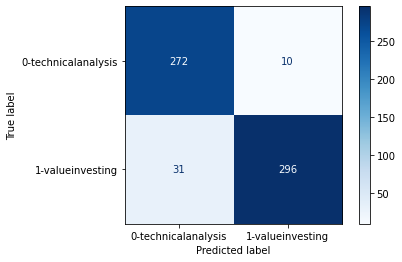

In [50]:
# Generate a confusion matrix.
# print out to cross-check
tn, fp, fn, tp = confusion_matrix(y_test, gs1_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting']);

In [51]:
# calculate metrics
accuracy = round((tp + tn) / (tn + fp + fn + tp),4)*100
print('Accuracy = ', accuracy)

sensitivity = round(tp / (tp + fn),4)*100
print('Sensitivity = ', sensitivity)

specificity = round(tn/ (tn + fp),4)*100
print('Specificity = ', specificity)

precision = round(tp /(tp + fp),4)*100
print('Precision = ', precision)

# put into a dataframe for comparison later
metric_cvec_logreg = [accuracy, sensitivity, specificity, precision]
metric_cvec_logreg_df = pd.DataFrame(metric_cvec_logreg,
                                     index = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision'],
                                     columns = ['model1_%'])
metric_cvec_logreg_df

Accuracy =  93.27
Sensitivity =  90.52
Specificity =  96.45
Precision =  96.73


model1_%
Accuracy        93.27
Sensitivity     90.52
Specificity     96.45
Precision       96.73

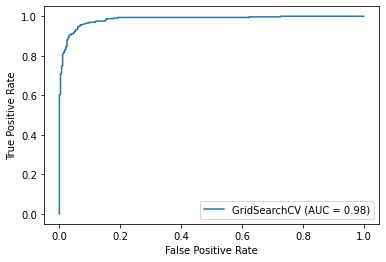

In [52]:
# plot roc auc curve
plot_roc_curve(gs1, X_test, y_test);

## Model 2 - TF-IDFVectorizor and Logistic Regression

Here we were only coding the progression and making sure that we got the required output. Discussion on observations of the models will be done at the next stage of 'Evaluating Model Results'.

In [53]:
# Let's set a pipeline up with two stages:
# 1. TF-IDFVectorizer (transformer)
# 2. LogisticRegression (estimator)
pipe2 = Pipeline([('tvec2', TfidfVectorizer(lowercase=True, stop_words=custom_stopwords, analyzer='word')),
                  ('logreg2', LogisticRegression())])

In [54]:
# Search over the following values of hyperparameters
pipe2_params = {
    'tvec2__max_features': [3000,5000,7000,9000],  # since we have <9000 columns from earlier steps
    'tvec2__min_df': [2,3],
    'tvec2__max_df': [0.8,0.9,1],
    'tvec2__ngram_range': [(1,1), (1,2)]}

In [55]:
# Instantiate GridSearchCV.
gs2 = GridSearchCV(pipe2, # what object are we optimizing?
                  param_grid = pipe2_params, # what parameters values are we searching?
                  cv=5,
                  n_jobs=4) # 5-fold cross-validation.

In [56]:
# Fit GridSearch to training data.
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec2',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [57]:
# What's the best score?
gs2.best_score_ # estimate of how model perform on unseen data cos CV

0.9400809716599191

In [58]:
# Save best model as gs_model.
gs2_model = gs2.best_estimator_
gs2_model

Pipeline(steps=[('tvec2',
                 TfidfVectorizer(max_df=0.8, max_features=3000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logreg2', LogisticRegression())])

In [59]:
# best parameters
gs2.best_params_

{'tvec2__max_df': 0.8,
 'tvec2__max_features': 3000,
 'tvec2__min_df': 3,
 'tvec2__ngram_range': (1, 2)}

In [60]:
# Generate our predictions
gs2_predictions = gs2.predict(X_test)
gs2_predictions

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,

In [61]:
# Score model on training set.
gs2_model.score(X_train, y_train)

0.9862348178137652

In [62]:
# Score model on testing set.
gs2_model.score(X_test, y_test)

0.9425287356321839

In [63]:
# store result in a dataframe for comparison later
results.append({'model':'Model2: TF-IDF Vectorizer and Logistic Regression',
                'best_params': gs2.best_params_,
                'accuracy_(CV_unseen_data)': round(gs2.best_score_,4)*100,
                'accuracy_(train)': round(gs2_model.score(X_train, y_train),4)*100,
                'accuracy_(test)': round(gs2_model.score(X_test, y_test),4)*100})
results_df = pd.DataFrame(results)
results_df

model  \
0    Model1: CountVectorizer and Logistic Regression   
1  Model2: TF-IDF Vectorizer and Logistic Regression   

                                         best_params  \
0  {'cvec1__max_df': 0.8, 'cvec1__max_features': ...   
1  {'tvec2__max_df': 0.8, 'tvec2__max_features': ...   

   accuracy_(CV_unseen_data)  accuracy_(train)  accuracy_(test)  
0                      91.98             99.60            93.27  
1                      94.01             98.62            94.25

True Negatives: 266
False Positives: 16
False Negatives: 19
True Positives: 308


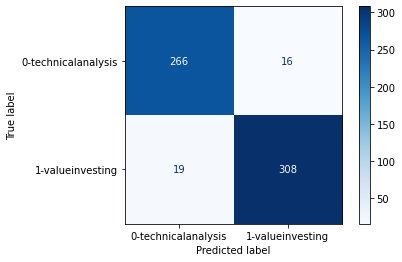

In [64]:
# Generate a confusion matrix.
# print out to cross check
tn, fp, fn, tp = confusion_matrix(y_test, gs2_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

plot_confusion_matrix(gs2, X_test, y_test, cmap='Blues', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting']);

In [65]:
# calculate metrics
accuracy = round((tp + tn) / (tn + fp + fn + tp),4)*100
print('Accuracy = ', accuracy)

sensitivity = round(tp / (tp + fn),4)*100
print('Sensitivity = ', sensitivity)

specificity = round(tn/ (tn + fp),4)*100
print('Specificity = ', specificity)

precision = round(tp /(tp + fp),4)*100
print('Precision = ', precision)

# put into a dataframe for comparison later
metric_tvec_logreg = [accuracy, sensitivity, specificity, precision]
metric_tvec_logreg_df = pd.DataFrame(metric_tvec_logreg,
                                     index = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision'],
                                     columns = ['model2_%'])
metric_tvec_logreg_df

Accuracy =  94.25
Sensitivity =  94.19
Specificity =  94.33
Precision =  95.06


model2_%
Accuracy        94.25
Sensitivity     94.19
Specificity     94.33
Precision       95.06

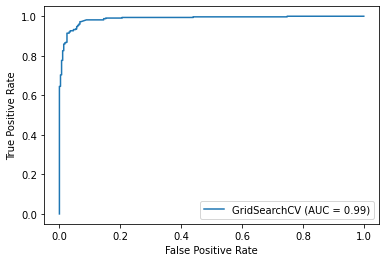

In [66]:
# plot roc auc curve
plot_roc_curve(gs2, X_test, y_test);

## Model 3 - CountVectorizer and Multinomial Naive Bayes

Here we were only coding the progression and making sure that we got the required output. Discussion on observations of the models will be done at the next stage of 'Evaluating Model Results'.

In [67]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. MultinomialNB (estimator)
pipe3 = Pipeline([('cvec3', CountVectorizer(lowercase=True, stop_words=custom_stopwords, analyzer='word')),
                  ('multiNB3', MultinomialNB())])

In [68]:
# Search over the following values of hyperparameters
pipe3_params = {
    'cvec3__max_features': [3000,5000,7000, 9000],  # since we have <9000 columns from earlier wordcloud steps
    'cvec3__min_df': [2,3],
    'cvec3__max_df': [0.8,0.9,1],
    'cvec3__ngram_range': [(1,1), (1,2)]}

In [69]:
# Instantiate GridSearchCV.
gs3 = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid = pipe3_params, # what parameters values are we searching?
                  cv=5,  # 5-fold cross-validation.
                  n_jobs=4)  # 4 jobs threads run faster

In [70]:
# Fit GridSearch to training data.
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec3',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [71]:
# What's the best score?
gs3.best_score_ # estimate of how model perform on unseen data cos CV

0.939271255060729

In [72]:
# Save best model as gs_model.
gs3_model = gs3.best_estimator_
gs3_model

Pipeline(steps=[('cvec3',
                 CountVectorizer(max_df=0.8, max_features=5000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('multiNB3', MultinomialNB())])

In [73]:
# best parameters
gs3.best_params_

{'cvec3__max_df': 0.8,
 'cvec3__max_features': 5000,
 'cvec3__min_df': 2,
 'cvec3__ngram_range': (1, 2)}

In [74]:
# Generate our predictions
gs3_predictions = gs3.predict(X_test)
gs3_predictions

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,

In [75]:
# Score model on training set.
gs3_model.score(X_train, y_train)

0.9765182186234818

In [76]:
# Score model on testing set.
gs3_model.score(X_test, y_test)

0.9359605911330049

In [77]:
# store result in a dataframe for comparison later
results.append({'model':'Model3: CountVectorizer and MultinomialNB',
                'best_params': gs3.best_params_,
                'accuracy_(CV_unseen_data)': round(gs3.best_score_,4)*100,
                'accuracy_(train)': round(gs3_model.score(X_train, y_train),4)*100,
                'accuracy_(test)': round(gs3_model.score(X_test, y_test),4)*100})
results_df = pd.DataFrame(results)
results_df

model  \
0    Model1: CountVectorizer and Logistic Regression   
1  Model2: TF-IDF Vectorizer and Logistic Regression   
2          Model3: CountVectorizer and MultinomialNB   

                                         best_params  \
0  {'cvec1__max_df': 0.8, 'cvec1__max_features': ...   
1  {'tvec2__max_df': 0.8, 'tvec2__max_features': ...   
2  {'cvec3__max_df': 0.8, 'cvec3__max_features': ...   

   accuracy_(CV_unseen_data)  accuracy_(train)  accuracy_(test)  
0                      91.98             99.60            93.27  
1                      94.01             98.62            94.25  
2                      93.93             97.65            93.60

True Negatives: 260
False Positives: 22
False Negatives: 17
True Positives: 310


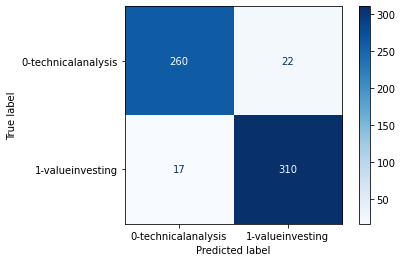

In [78]:
# Generate a confusion matrix.
# print out to cross check
tn, fp, fn, tp = confusion_matrix(y_test, gs3_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

plot_confusion_matrix(gs3, X_test, y_test, cmap='Blues', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting']);

In [79]:
# calculate metrics
accuracy = round((tp + tn) / (tn + fp + fn + tp),4)*100
print('Accuracy = ', accuracy)

sensitivity = round(tp / (tp + fn),4)*100
print('Sensitivity = ', sensitivity)

specificity = round(tn/ (tn + fp),4)*100
print('Specificity = ', specificity)

precision = round(tp /(tp + fp),4)*100
print('Precision = ', precision)

# put into a dataframe for comparison later
metric_cvec_multiNB = [accuracy, sensitivity, specificity, precision]
metric_cvec_multiNB_df = pd.DataFrame(metric_cvec_multiNB,
                                     index = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision'],
                                     columns = ['model3_%'])
metric_cvec_multiNB_df

Accuracy =  93.60000000000001
Sensitivity =  94.8
Specificity =  92.2
Precision =  93.37


model3_%
Accuracy        93.60
Sensitivity     94.80
Specificity     92.20
Precision       93.37

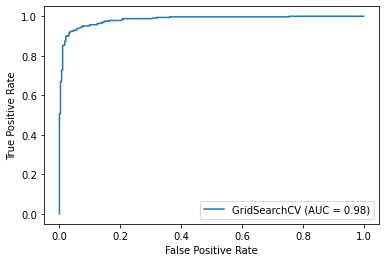

In [80]:
# plot roc auc curve
plot_roc_curve(gs3, X_test, y_test);

## Model 4 -  TF-IDFVectorizer and Multinomial Naive Bayes

Here we were only coding the progression and making sure that we got the required output. Discussion on observations of the models will be done at the next stage of 'Evaluating Model Results'.

In [81]:
# Let's set a pipeline up with two stages:
# 1. TF-IDFVectorizer (transformer)
# 2. MultinomialNB (estimator)
pipe4 = Pipeline([('tvec4', TfidfVectorizer(lowercase=True, stop_words=custom_stopwords, analyzer='word')),
                 ('multiNB4', MultinomialNB())])

In [82]:
# Search over the following values of hyperparameters
pipe4_params = {
    'tvec4__max_features': [3000,5000,7000,9000],  # since we have <9000 columns from earlier wordcloud steps
    'tvec4__min_df': [2,3],
    'tvec4__max_df': [0.8,0.9,1],
    'tvec4__ngram_range': [(1,1), (1,2)]}

In [83]:
# Instantiate GridSearchCV.
gs4 = GridSearchCV(pipe4, # what object are we optimizing?
                  param_grid = pipe4_params, # what parameters values are we searching?
                  cv=5,  # 5-fold cross-validation.
                  n_jobs=4)  # 4 jobs threads run faster

In [84]:
# Fit GridSearch to training data.
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec4',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [85]:
# What's the best score?
gs4.best_score_ # estimate of how model perform on unseen data cos CV

0.9295546558704453

In [86]:
# Save best model as gs_model.
gs4_model = gs4.best_estimator_
gs4_model

Pipeline(steps=[('tvec4',
                 TfidfVectorizer(max_df=0.8, max_features=3000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('multiNB4', MultinomialNB())])

In [87]:
# best parameters
gs4.best_params_

{'tvec4__max_df': 0.8,
 'tvec4__max_features': 3000,
 'tvec4__min_df': 2,
 'tvec4__ngram_range': (1, 2)}

In [88]:
# Generate our predictions
gs4_predictions = gs4.predict(X_test)
gs4_predictions

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,

In [89]:
# Score model on training set.
gs4_model.score(X_train, y_train)

0.9700404858299595

In [90]:
# Score model on testing set.
gs4_model.score(X_test, y_test)

0.9359605911330049

In [91]:
# store result in a dataframe for comparison later
results.append({'model':'Model4: TF-IDF Vectorizer and MultinomialNB',
                'best_params': gs4.best_params_,
                'accuracy_(CV_unseen_data)': round(gs4.best_score_,4)*100,
                'accuracy_(train)': round(gs4_model.score(X_train, y_train),4)*100,
                'accuracy_(test)': round(gs4_model.score(X_test, y_test),4)*100})
results_df = pd.DataFrame(results)
results_df

model  \
0    Model1: CountVectorizer and Logistic Regression   
1  Model2: TF-IDF Vectorizer and Logistic Regression   
2          Model3: CountVectorizer and MultinomialNB   
3        Model4: TF-IDF Vectorizer and MultinomialNB   

                                         best_params  \
0  {'cvec1__max_df': 0.8, 'cvec1__max_features': ...   
1  {'tvec2__max_df': 0.8, 'tvec2__max_features': ...   
2  {'cvec3__max_df': 0.8, 'cvec3__max_features': ...   
3  {'tvec4__max_df': 0.8, 'tvec4__max_features': ...   

   accuracy_(CV_unseen_data)  accuracy_(train)  accuracy_(test)  
0                      91.98             99.60            93.27  
1                      94.01             98.62            94.25  
2                      93.93             97.65            93.60  
3                      92.96             97.00            93.60

True Negatives: 253
False Positives: 29
False Negatives: 10
True Positives: 317


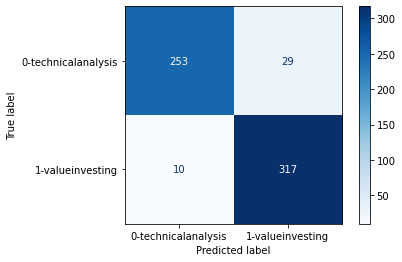

In [92]:
# Generate a confusion matrix.
# print out to cross check
tn, fp, fn, tp = confusion_matrix(y_test, gs4_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

plot_confusion_matrix(gs4, X_test, y_test, cmap='Blues', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting']);

In [93]:
# calculate metrics
accuracy = round((tp + tn) / (tn + fp + fn + tp),4)*100
print('Accuracy = ', accuracy)

sensitivity = round(tp / (tp + fn),4)*100
print('Sensitivity = ', sensitivity)

specificity = round(tn/ (tn + fp),4)*100
print('Specificity = ', specificity)

precision = round(tp /(tp + fp),4)*100
print('Precision = ', precision)

# put into a dataframe for comparison later
metric_tvec_multiNB = [accuracy, sensitivity, specificity, precision]
metric_tvec_multiNB_df = pd.DataFrame(metric_tvec_multiNB,
                                     index = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision'],
                                     columns = ['model4_%'])
metric_tvec_multiNB_df

Accuracy =  93.60000000000001
Sensitivity =  96.94
Specificity =  89.72
Precision =  91.62


model4_%
Accuracy        93.60
Sensitivity     96.94
Specificity     89.72
Precision       91.62

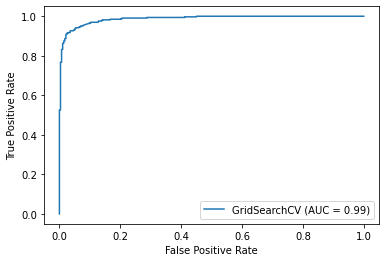

In [94]:
# plot roc auc curve
plot_roc_curve(gs4, X_test, y_test);

# Evaluating models results

Having created 4 models, we evaluated the models by comparing their Confusion Matrices and metrics that were calculated in the earlier steps.

In this case, since we were primarily concerned with predicting whether a post came from the `valueinvesting` subreddit or not. The Accuracy metric will be the most appropriate. Accuracy is a good measure when the target variable classes in the data are nearly balanced. However, we looked at other metrics as well such as:

- **Accuracy = (TP + TN) / (TP + TN + FP + FN)**
- Sensitivity = TP / (TP + FN)
- Specificity = TN / (TN + FP)
- Precision = TP / (TP + FP)
- AUC ROC

As a reminder to interpreting confusion matrices:

**How do I keep true positives/true negatives/false positives/false negatives straight?**
- First word (true/false): Was the model right?
- Second word (positive/negative): What did the model predict?

## Accuracy, Sensitivity, Specificity, Precision

In [95]:
# adding var columns for easy comparison
results_df['var_(train-test)'] = results_df['accuracy_(train)'] - results_df['accuracy_(test)']
results_df['var_(unseen_data-test)'] = results_df['accuracy_(CV_unseen_data)'] - results_df['accuracy_(test)']
results_df

model  \
0    Model1: CountVectorizer and Logistic Regression   
1  Model2: TF-IDF Vectorizer and Logistic Regression   
2          Model3: CountVectorizer and MultinomialNB   
3        Model4: TF-IDF Vectorizer and MultinomialNB   

                                         best_params  \
0  {'cvec1__max_df': 0.8, 'cvec1__max_features': ...   
1  {'tvec2__max_df': 0.8, 'tvec2__max_features': ...   
2  {'cvec3__max_df': 0.8, 'cvec3__max_features': ...   
3  {'tvec4__max_df': 0.8, 'tvec4__max_features': ...   

   accuracy_(CV_unseen_data)  accuracy_(train)  accuracy_(test)  \
0                      91.98             99.60            93.27   
1                      94.01             98.62            94.25   
2                      93.93             97.65            93.60   
3                      92.96             97.00            93.60   

   var_(train-test)  var_(unseen_data-test)  
0              6.33                   -1.29  
1              4.37                   -0.24  
2              4.05                    0.33  
3              3.40                   -0.64

**Observation**

From the comparison above:
- All models showed overfitting on the train data as train score was better than cross-validation score on unseen data.
- Test scores were almost same as cross-validation score on unseen data but lower than train score. This meant all four models generalized well.
- Strictly speaking by Accuracy of test data, `Model 2: TD-IDFVectorizer and LogisticRegression` will be the best at this point.
- Model 2 had the smallest difference (-0.24%) between test accuracy and cross-validation accuracy on unseen data. Its overfitting was also the 2nd lowest.

In our case, we recall that the Baseline (dumb model) prediction for Class 1 `valueinvesting` was 53.69%. All the four models did better than that. Let recall the other metrics for a more holistic comparison.

In [96]:
# combine all metrics dataframe for easy comparison
metric_all_df = pd.concat([metric_cvec_logreg_df, metric_tvec_logreg_df, metric_cvec_multiNB_df,metric_tvec_multiNB_df], axis=1)
metric_all_df.reset_index(inplace=True)
metric_all_df.rename(columns={'index':'metrics'}, inplace=True)
metric_all_df

metrics  model1_%  model2_%  model3_%  model4_%
0     Accuracy     93.27     94.25     93.60     93.60
1  Sensitivity     90.52     94.19     94.80     96.94
2  Specificity     96.45     94.33     92.20     89.72
3    Precision     96.73     95.06     93.37     91.62

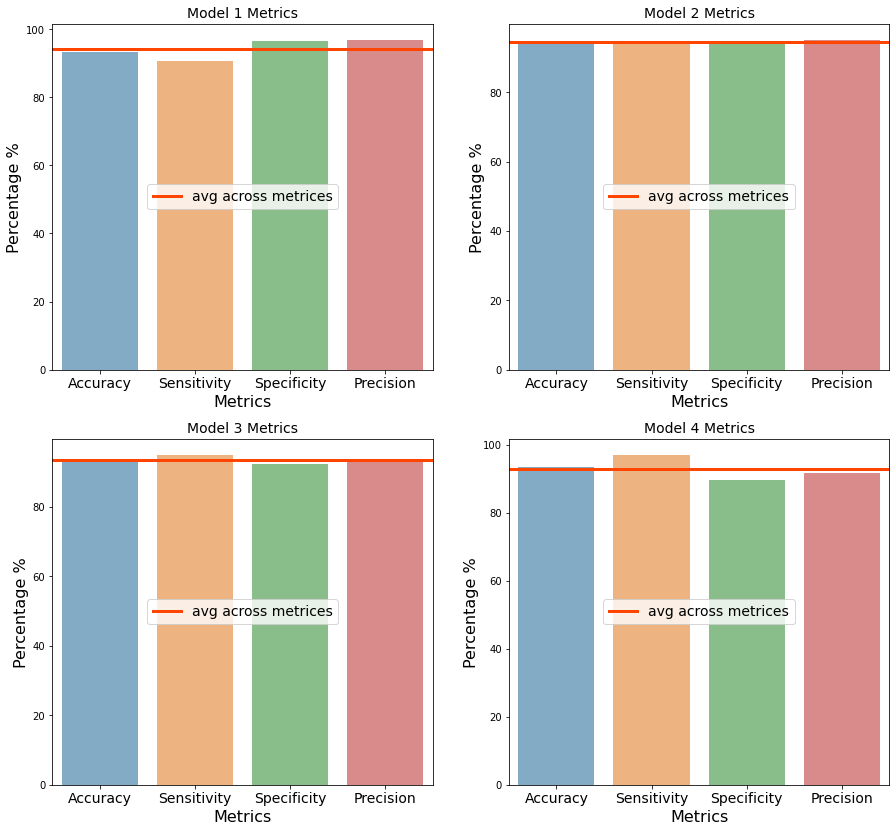

In [97]:
# plots for metrices
fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2, figsize=(15,14), facecolor="white")

sns.barplot(x='metrics', y='model1_%', data=metric_all_df, ax=ax1, alpha=0.6)
sns.barplot(x='metrics', y='model2_%', data=metric_all_df, ax=ax2, alpha=0.6)
sns.barplot(x='metrics', y='model3_%', data=metric_all_df, ax=ax3, alpha=0.6)
sns.barplot(x='metrics', y='model4_%', data=metric_all_df, ax=ax4, alpha=0.6);

# average total % across metrices and across percentage
ax1.axhline(metric_all_df['model1_%'].sum()/4,0, ls='-', color='orangered', lw=3, label="avg across metrices")
ax2.axhline(metric_all_df['model2_%'].sum()/4,0, ls='-', color='orangered', lw=3, label="avg across metrices")
ax3.axhline(metric_all_df['model3_%'].sum()/4,0, ls='-', color='orangered', lw=3, label="avg across metrices")
ax4.axhline(metric_all_df['model4_%'].sum()/4,0, ls='-', color='orangered', lw=3, label="avg across metrices")
ax1.legend(loc='center', fontsize=14)
ax2.legend(loc='center', fontsize=14)
ax3.legend(loc='center', fontsize=14)
ax4.legend(loc='center', fontsize=14)

ax1.set_title("Model 1 Metrics", fontsize=14)
ax1.set_xlabel("Metrics", fontsize=16)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=14)
ax1.set_ylabel("Percentage %", fontsize=16);

ax2.set_title("Model 2 Metrics", fontsize=14)
ax2.set_xlabel("Metrics", fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=14)
ax2.set_ylabel("Percentage %", fontsize=16);

ax3.set_title("Model 3 Metrics", fontsize=14)
ax3.set_xlabel("Metrics", fontsize=16)
ax3.set_xticklabels(ax3.get_xticklabels(), fontsize=14)
ax3.set_ylabel("Percentage %", fontsize=16);

ax4.set_title("Model 4 Metrics", fontsize=14)
ax4.set_xlabel("Metrics", fontsize=16)
ax4.set_xticklabels(ax4.get_xticklabels(), fontsize=14)
ax4.set_ylabel("Percentage %", fontsize=16);

In [98]:
# checking values to be sure
print('Model1 sum of matrices % = ', round(metric_all_df['model1_%'].sum(),2))
print('Model2 sum of matrices % = ', round(metric_all_df['model2_%'].sum(),2))
print('Model3 sum of matrices % = ', round(metric_all_df['model3_%'].sum(),2))
print('Model4 sum of matrices % = ', round(metric_all_df['model4_%'].sum(),2),'\n')
print('Model1 mean of matrices % = ', round(metric_all_df['model1_%'].mean(),2))
print('Model2 mean of matrices % = ', round(metric_all_df['model2_%'].mean(),2))
print('Model3 mean of matrices % = ', round(metric_all_df['model3_%'].mean(),2))
print('Model4 mean of matrices % = ', round(metric_all_df['model4_%'].mean(),2))

Model1 sum of matrices % =  376.97
Model2 sum of matrices % =  377.83
Model3 sum of matrices % =  373.97
Model4 sum of matrices % =  371.88 

Model1 mean of matrices % =  94.24
Model2 mean of matrices % =  94.46
Model3 mean of matrices % =  93.49
Model4 mean of matrices % =  92.97


As for the other metrices, generally higher was better in our case. So a simple sum of mean of all the metrics percentage would suffice to give a holistic comparison.

    - Accuracy:    How many of all observations did the model predicted correctly?
    - Sensitivity: Among all true positives, how many did the model predicted correctly? (also known as recall).
    - Specificity: Among all true negatives, how many did the model predicted correctly?
    - Precision:   Among the true and false positives, how many did the model predicted correctly?

From the table and barplots, **`Model 2 - TD-IDFVectorizer and LogisticRegression`** again had the best overall performance across all metrices. At this point, we pretty much observed that Model 2 was the best model but let's take a last look at the ROC AUC curves and Confusion Matrices.

## ROC AUC Curves

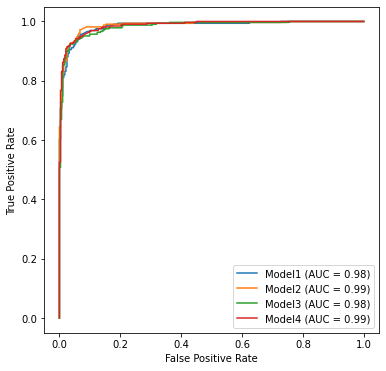

In [99]:
fig, ax = plt.subplots(1,1, figsize=(6,6), facecolor="white")
plot_roc_curve(gs1, X_test, y_test, name='Model1', ax=ax)
plot_roc_curve(gs2, X_test, y_test, name='Model2', ax=ax)
plot_roc_curve(gs3, X_test, y_test, name='Model3', ax=ax)
plot_roc_curve(gs4, X_test, y_test, name='Model4', ax=ax);

**Observation**

For each model we calculated their ROC-AUC score. The ROC (receiver operating characteristic) shows a binary classification model's ability to distinguish between two classes. The AUC (area under the curve) is how we measure the distribution of the classes.
- 0.5 is the lowest possible and 1.0 is the highest.
- Higher is better at classifying the classes with lesser overlaps.

In our case, all four models returned very high AUC scores which was good but this metric does not help us much in identifying the better model. Next, we looked into the Confusion Matrices.

## Confusion Matrices

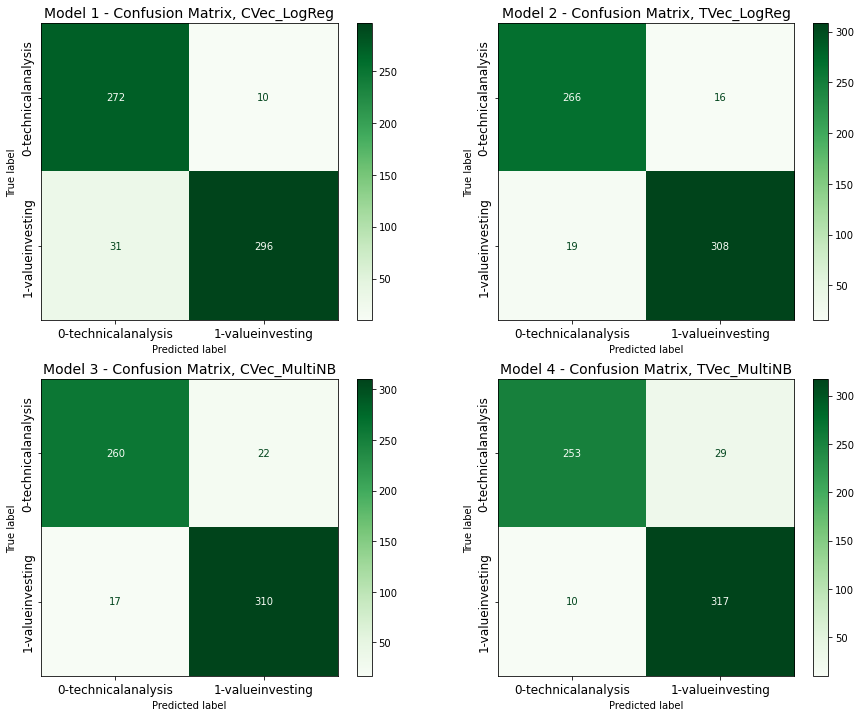

In [100]:
# plots for confusion matrices
fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2, figsize=(15,12), facecolor="white")

plot_confusion_matrix(gs1, X_test, y_test, cmap='Greens', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting'], ax=ax1);
ax1.set_title("Model 1 - Confusion Matrix, CVec_LogReg", fontsize=14)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=90,
                    verticalalignment='center', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

plot_confusion_matrix(gs2, X_test, y_test, cmap='Greens', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting'], ax=ax2);
ax2.set_title("Model 2 - Confusion Matrix, TVec_LogReg", fontsize=14)
ax2.set_yticklabels(ax1.get_yticklabels(), rotation=90,
                    verticalalignment='center', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plot_confusion_matrix(gs3, X_test, y_test, cmap='Greens', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting'], ax=ax3);
ax3.set_title("Model 3 - Confusion Matrix, CVec_MultiNB", fontsize=14)
ax3.set_yticklabels(ax1.get_yticklabels(), rotation=90,
                    verticalalignment='center', fontsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

plot_confusion_matrix(gs4, X_test, y_test, cmap='Greens', values_format='d',
                      display_labels=['0-technicalanalysis', '1-valueinvesting'], ax=ax4);
ax4.set_title("Model 4 - Confusion Matrix, TVec_MultiNB", fontsize=14);
ax4.set_yticklabels(ax1.get_yticklabels(), rotation=90,
                    verticalalignment='center', fontsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12);

**Observation**

The confusion matrices showed the number of true or false predictions against their actual classification. It was a good way to visualize if there was any major skew in the prediction results. Since `Model 2 - TF-IDFVectorizer and LogisticRegression` was the apparent best model, let's take a closer look.

- **True Positives (TP)** meant predict=positive(1) and actual=positive(1). In this case, since `valueinvesting` = 1, a true positive meant that the model **correctly** predicted 308 out of 609 records that it was coming from `valueinvesting` subreddit and they did.


- **False Positives (FP)** meant predict=positive(1) but actual=negative(0). In this case, since `valueinvesting` = 1, a false positive meant that the model **incorrectly** predicted 16 out of 609 records that it was coming from `valueinvesting` subreddit but they were not.


- **False Negatives (FN)** meant predict=negative(0) but actual=positive(1). In this case, since `valueinvesting` = 1, a false negative meant that the model **incorrectly** predicted 19 out of 609 records that it was **NOT** coming from `valueinvesting` subreddit but they did.


- **True Negatives (TN)** meant predict=negative(0) and actual=negative(0). In this case, since `valueinvesting` = 1, a true negative meant that the model **correctly** predicted 266 out of 609 records that it was **NOT** coming from `valueinvesting` subreddit and they were not.

We knew that there will be some error associated with every model that we used for predicting the true class of the target variable. This resulted in False Positives and False Negatives (i.e Model classifying things incorrectly as compared to the actual class). There was no hard rule on what should be minimized/maximized in all the situations. It purely depended on the business needs and the context of the problem we were trying to solve. In our case, we wanted to minimize either False Positives and False Negatives. Vice versa, maximize True Positives and True Negatives.

- Model 1: FP+FN = 10+31 = 41
- **Model 2: FP+FN = 16+19 = 35 (smaller is better meaning model is making lesser mistakes i.e. misclassification)**
- Model 3: FP+FN = 22+17 = 39
- Model 4: FP+FN = 29+10 = 39


- Model 1: TP+TN = 296+272 = 568
- **Model 2: TP+TN = 308+266 = 574 (bigger is better meaning model is making more right predictions. i.e. accuracy)**
- Model 3: TP+TN = 310+260 = 570
- Model 4: TP+TN = 317+253 = 570

In comparison with other models, `Model 2 - TF-IDFVectorizer and LogisticRegression` produced the best result in making lesser mistakes and making the most correct predictions. Finally, we wanted to look at the top predictor words to be sure that it made sense from a domain perspective.

## Top predictor words

Let's look at the top predictors words that Model 2 used to determine if a post was coming from the `valueinvesting` subreddit.

In [101]:
# list the coef
# note: gs2 was assign to model 2 in above steps.
gs2_model.steps[1][1].coef_
# why [1][1]?
# type(gs2_model.steps) return 'list'
# gs2_model.steps[0] stores the data used by tvec
# gs2_model.steps[1] stores the data of logreg
# gs2_model.steps[1][1] to access the coef of logreg

array([[-0.07539631,  0.23128139, -0.01099319, ...,  0.04981769,
        -0.61600987,  0.08880658]])

In [102]:
# putting into a df for concat later
gs2_coef_df = pd.DataFrame(gs2_model.steps[1][1].coef_.ravel())
gs2_coef_df.rename(columns={0:'coef'}, inplace=True)
gs2_coef_df.sample(frac=1).head()

coef
1691  0.315833
2385  0.264280
2214  0.029805
2860  0.302017
2303 -0.538150

In [103]:
# list the features
gs2_model.steps[0][1].get_feature_names()
# why [0][1]?
# type(gs2_model.steps) return 'list'
# gs2_model.steps[0] stores the data used by tvec
# gs2_model.steps[0][1] to access the feature names of tvec

['00',
 '000',
 '02',
 '04',
 '04 2019',
 '05',
 '06',
 '07',
 '08',
 '09',
 '09 2020',
 '10',
 '10 10',
 '10 15',
 '10 2020',
 '10 year',
 '100',
 '1000',
 '10k',
 '10x',
 '11',
 '12',
 '13',
 '14',
 '14th',
 '15',
 '15 year',
 '16',
 '164',
 '17',
 '18',
 '19',
 '19 year',
 '1994',
 '1996',
 '1997',
 '1h',
 '1st',
 '20',
 '20 year',
 '200',
 '2000',
 '2003',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2016',
 '2017',
 '2018',
 '2019',
 '2019 dax',
 '2019 wa',
 '2020',
 '2020 05',
 '2021',
 '2022',
 '21',
 '215',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2nd',
 '30',
 '30 50',
 '300',
 '31',
 '32',
 '33',
 '34',
 '35',
 '350',
 '36',
 '37',
 '38',
 '3x',
 '40',
 '400',
 '4096',
 '4096 format',
 '41',
 '43',
 '44',
 '45',
 '46',
 '48',
 '49',
 '4th',
 '4x',
 '50',
 '50 day',
 '500',
 '500 stock',
 '500 technic',
 '53',
 '55',
 '5g',
 '5th',
 '5y',
 '60',
 '600',
 '65',
 '66',
 '6th',
 '70',
 '700',
 '71',
 '75',
 '77',
 '80',
 '85',
 '90',
 '95',
 '96',
 '99

In [104]:
# putting into a df for concat later
gs2_feat_df = pd.DataFrame(gs2_model.steps[0][1].get_feature_names())
gs2_feat_df.rename(columns={0:'predictor_words'}, inplace=True)
gs2_feat_df.sample(frac=1).head()

predictor_words
2123          reason
914            elect
1968         potenti
1706   michael burri
1815            okay

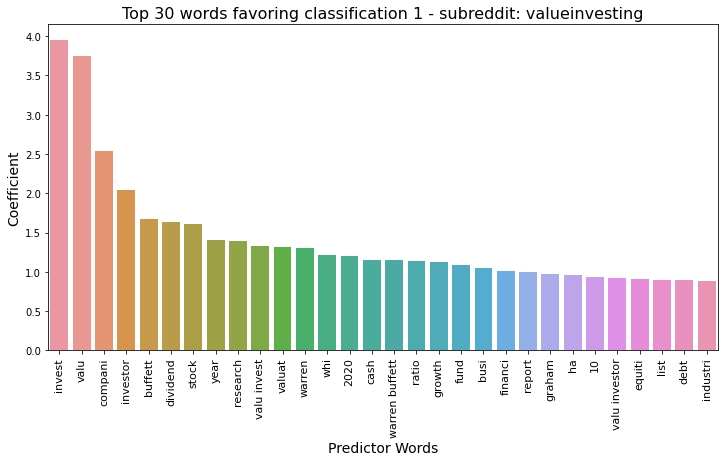

In [105]:
# join and get top 30 words favoring classification 1 - subreddit: valueinvesting
gs2_df = pd.concat([gs2_coef_df, gs2_feat_df], axis=1)
gs2_coef_top30words_value_df = gs2_df.sort_values(by='coef', ascending=False).head(30)
plt.figure(figsize = (12,6), facecolor = "white")
sns.barplot(x='predictor_words', y='coef', data=gs2_coef_top30words_value_df)
plt.title("Top 30 words favoring classification 1 - subreddit: valueinvesting", size = 16)
plt.xlabel("Predictor Words", size = 14)
plt.xticks(rotation=90, fontsize=11)
plt.ylabel("Coefficient", size = 14)
plt.show()

**Observation**

Applying domain knowledge in value investing, we could see that the top 20 predictor words were indeed closely related to the subreddit class. For example:
- 'buffett' was closely linked to the famous value investor 'Warren Buffett'.
- 'valu' (stemmed from value) and 'valuat' (stemmed from valuation) were words that posters who were into value investing would be familiar with.
- 'ratio', 'dividend', 'growth', 'fund' were closely linked to value investors as well.

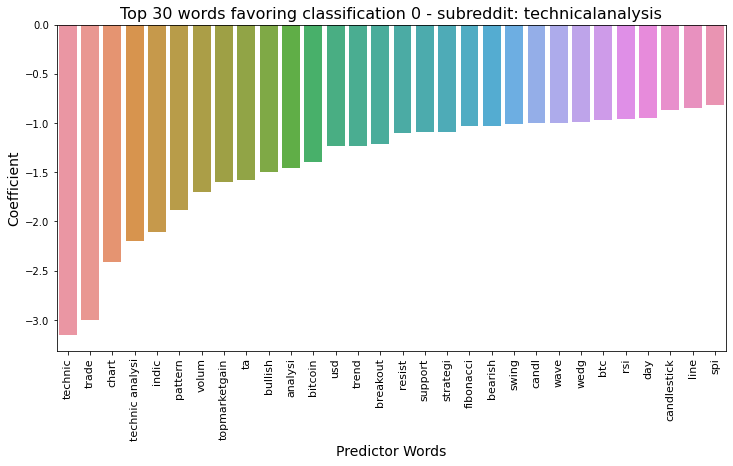

In [106]:
# get top 30 words favoring classification 0 - subreddit: valueinvesting
gs2_coef_wordstop30_technical_df = gs2_df.sort_values(by='coef', ascending=True).head(30)
plt.figure(figsize = (12,6), facecolor = "white")
sns.barplot(x='predictor_words', y='coef', data=gs2_coef_wordstop30_technical_df)
plt.title("Top 30 words favoring classification 0 - subreddit: technicalanalysis", size = 16)
plt.xlabel("Predictor Words", size = 14)
plt.xticks(rotation=90, fontsize=11)
plt.ylabel("Coefficient", size = 14)
plt.show()

**Observation**

Applying domain knowledge in technical analysis, we could see that the top 30 predictor words were indeed closely related to the subreddit class. For example:
- 'indic' (stemmed of 'indicator'), 'pattern', 'ta', 'bitcoin' and 'trend' were words that would be used by posters who were already familiar with the topic of technical analysis.
- 'fibonacci', 'candl'  (stemmed of candle), 'volum' (stemmed of volume), 'breakout' and 'resis' (stemmed of resistance) were technical analysis charting methods commonly used by technical investors.

## Look at records that were mis-classified

Mis-classified records are the False Negatives and False Negatives and we extracted them here to look deeper into why they were being misclassified. It would be tedious to examine word by word why the model mis-classified them, so we tried to analyze using two methods:
- **Simple method :** visual comparison with original text and validate count of words against top 30 words in each subreddit. Domain knowledge would be applied here as well.

- **Enhanced method:** tabulate coefficient scores of words found + not found in top 30 words to determine the favored classification by the model.

Some examples are demonstrated below since we would not be able to do for all mis-classifications.

**Getting the data together for easy comparison**

In [107]:
# extract the predict proba for analysis
# segregating coef for class 0 and class 1
gs2_proba_df = pd.DataFrame(gs2.predict_proba(X_test))
gs2_proba_df.rename(columns={0: 'Class 0 - technicalanalysis_proba',
                             1: 'Class 1 - valueinvesting_proba'}, inplace=True)
print(gs2_proba_df.shape)
gs2_proba_df.head()

(609, 2)


Class 0 - technicalanalysis_proba  Class 1 - valueinvesting_proba
0                           0.531151                        0.468849
1                           0.074184                        0.925816
2                           0.116454                        0.883546
3                           0.589643                        0.410357
4                           0.064919                        0.935081

In [108]:
# extract and combine the stemmed_text
gs2_proba_df = pd.concat([gs2_proba_df,pd.DataFrame(X_test).reset_index(drop=True)], axis=1, join='outer')
gs2_proba_df

Class 0 - technicalanalysis_proba  Class 1 - valueinvesting_proba  \
0                             0.531151                        0.468849   
1                             0.074184                        0.925816   
2                             0.116454                        0.883546   
3                             0.589643                        0.410357   
4                             0.064919                        0.935081   
..                                 ...                             ...   
604                           0.673615                        0.326385   
605                           0.726850                        0.273150   
606                           0.167185                        0.832815   
607                           0.032413                        0.967587   
608                           0.870021                        0.129979   

                                          stemmed_text  
0                                            long aaba  
1    warren buffett s top 6 tip for invest in the s...  
2    whi you shouldn t grow too comfort with the st...  
3              brexit deal gold price close in on 1500  
4    screen for consist good companiesi have thi pa...  
..                                                 ...  
604  resist at the 78 6 fib level if it break throu...  
605  odd of success stream ta basic i want to be a ...  
606  valu invest newsletterhello all i would love s...  
607                  how to invest like warren buffett  
608  basic attent token mid term technic analysi ba...  

[609 rows x 3 columns]

In [109]:
# extract and combine the True subreddit_class
gs2_proba_df = gs2_proba_df.merge(data_df[['subreddit_class', 'unclean_text']],
                                  left_on=gs2_proba_df['stemmed_text'],
                                  right_on=data_df['stemmed_text'],
                                  how='left')
gs2_proba_df.drop('key_0', axis=1, inplace=True)
gs2_proba_df.head()

Class 0 - technicalanalysis_proba  Class 1 - valueinvesting_proba  \
0                           0.531151                        0.468849   
1                           0.074184                        0.925816   
2                           0.116454                        0.883546   
3                           0.589643                        0.410357   
4                           0.064919                        0.935081   

                                        stemmed_text  subreddit_class  \
0                                          long aaba                0   
1  warren buffett s top 6 tip for invest in the s...                1   
2  whi you shouldn t grow too comfort with the st...                1   
3            brexit deal gold price close in on 1500                0   
4  screen for consist good companiesi have thi pa...                1   

                                        unclean_text  
0                                       Long AABA---  
1  Warren Buffett's Top 6 Tips For Investing In T...  
2  Why you shouldn't grow too comfortable with th...  
3  🏳️BREXIT DEAL +⭐GOLD PRICE CLOSING IN ON $1500---  
4  Screening for consistently good companiesI hav...

In [110]:
gs2_proba_df.shape

(609, 5)

In [111]:
gs2_proba_df['predict_class'] = [1 if i >= 0.5 else 0 for i in gs2_proba_df['Class 1 - valueinvesting_proba']]
gs2_proba_df.sample(frac=1).head()

Class 0 - technicalanalysis_proba  Class 1 - valueinvesting_proba  \
591                           0.723327                        0.276673   
330                           0.789073                        0.210927   
347                           0.346866                        0.653134   
500                           0.632197                        0.367803   
146                           0.236894                        0.763106   

                                          stemmed_text  subreddit_class  \
591  best book for learn technic analysi for a begi...                0   
330  liquidityar there other type of indic other th...                0   
347     how appl achiev 16 yoy revenu growth in servic                1   
500      dp weekli wrap intern support substanti errod                0   
146  stock return finder scrape yahoo financ for a ...                1   

                                          unclean_text  predict_class  
591  Best book for learning technical analysis for ...              0  
330  LiquidityAre there other types of indicators o...              0  
347  How Apple Achieved 16% YoY Revenue Growth in S...              1  
500  DP WEEKLY WRAP: Internal Support Substantially...              0  
146  Stock Returns Finder: Scraping Yahoo Finance f...              1

### False Positives

- **False Positives (FP)** meant predict=positive(1) but actual=negative(0). In this case, since `valueinvesting` = 1, a false positive meant that the model **incorrectly** predicted 16 out of 609 records that it was coming from `valueinvesting` subreddit but they were not.

In [112]:
# extracting the False Positives
print('No of False Positives in Model2 = ',
      gs2_proba_df[(gs2_proba_df['predict_class']==1) & (gs2_proba_df['subreddit_class']==0)].shape[0])

# displaying top 3 False Positves
gs2_proba_df[(gs2_proba_df['predict_class']==1) & (gs2_proba_df['subreddit_class']==0)].sort_values(
    by='Class 1 - valueinvesting_proba', ascending=False).head(3)

No of False Positives in Model2 =  16


Class 0 - technicalanalysis_proba  Class 1 - valueinvesting_proba  \
209                           0.258670                        0.741330   
308                           0.289731                        0.710269   
72                            0.334835                        0.665165   

                                          stemmed_text  subreddit_class  \
209                       us 10 year bond what is next                0   
308  best uk zero commiss invest app freetrad ig pl...                0   
72    godaddi inc time to sell now and cash the profit                0   

                                          unclean_text  predict_class  
209                 US 10 Years BOND: What is next?---              1  
308  Best UK Zero Commission Investment App - FreeT...              1  
72   Godaddy Inc., time to sell now and cash the pr...              1

In [113]:
# display in full for analysis
# this is actually coming from technicalanalysis but model2 predicted it to be from valueinvesting
print('Original post:\n', gs2_proba_df.iloc[209,4],'\n')
print('Stemmed text:\n', gs2_proba_df.iloc[209,2], '\n')

count_value=0
count_technical=0
found_in_top30words_value=[]
found_in_top30words_technical=[]

for word in gs2_proba_df.iloc[209,2].split():
    if word in " ".join(gs2_coef_top30words_value_df['predictor_words']):
        count_value+=1
        found_in_top30words_value.append(word)
    elif word in " ".join(gs2_coef_wordstop30_technical_df['predictor_words']):
        count_technical+=1
        found_in_top30words_technical.append(word)
print('No of words found in valueinvesting top 30 words =', count_value)
print('They were', found_in_top30words_value, '\n')
print('No of words found in technicalanalysis top 30 words =', count_technical)
print('They were', found_in_top30words_technical, '\n')    

Original post:
 US 10 Years BOND: What is next?--- 

Stemmed text:
 us 10 year bond what is next 

No of words found in valueinvesting top 30 words = 4
They were ['us', '10', 'year', 'is'] 

No of words found in technicalanalysis top 30 words = 0
They were [] 



**Observation**

- **False Positives (FP)** meant predict=positive(1) but actual=negative(0). In this case, since `valueinvesting` = 1, a false positive meant that the model **incorrectly** predicted 16 out of 609 records that it was coming from `valueinvesting` subreddit but they were not.

**Why Model2 think that this was from `valueinvesting`:**
- Words like `10`, `year` were most likely the reason as these were among the top 30 words found in `valueinvesting` post. Words like `us` and `is` although were not in the top 30 words but they were found in `valueinvesting` and contributed to the model score favouring `valueinvesting`.

**Why Model2 did not think that this was from `technicalanalysis`:**
- None of the words was coming from the top 30 words from `technicalanalysis`. Hence, the model count would naturally favor `valueinvesting`.

In [114]:
# display in full for analysis
# this is actually coming from technicalanalysis but model2 predicted it to be from valueinvesting
print('Original post:\n', gs2_proba_df.iloc[308,4],'\n')
print('Stemmed text:\n', gs2_proba_df.iloc[308,2],'\n')

count_value=0
count_technical=0
found_in_top30words_value=[]
found_in_top30words_technical=[]

for word in gs2_proba_df.iloc[308,2].split():
    if word in " ".join(gs2_coef_top30words_value_df['predictor_words']):
        count_value+=1
        found_in_top30words_value.append(word)
    elif word in " ".join(gs2_coef_wordstop30_technical_df['predictor_words']):
        count_technical+=1
        found_in_top30words_technical.append(word)
print('No of words found in valueinvesting top 30 words =', count_value)
print('They were', found_in_top30words_value, '\n')
print('No of words found in technicalanalysis top 30 words =', count_technical)
print('They were', found_in_top30words_technical, '\n')    

Original post:
 Best UK Zero Commission Investment App - FreeTrade, IG, Plus500, eToro, ...--- 

Stemmed text:
 best uk zero commiss invest app freetrad ig plus500 etoro 

No of words found in valueinvesting top 30 words = 1
They were ['invest'] 

No of words found in technicalanalysis top 30 words = 0
They were [] 



**Observation**

**Why Model2 think that this was from `valueinvesting`:**
- Word like `invest` was a word with the highest coefficient among the top 30 words in `valueinvesting`.

**Why Model2 did not think that this was from `technicalanalysis`:**
- None of the words was coming from the top 30 words from `technicalanalysis`. Hence, the model count would naturally favor `valueinvesting`.

In [115]:
# display in full for analysis
# this is actually coming from technicalanalysis but model2 predicted it to be from valueinvesting
print('Original post:\n', gs2_proba_df.iloc[72,4],'\n')
print('Stemmed text:\n', gs2_proba_df.iloc[72,2], '\n')

count_value=0
count_technical=0
found_in_top30words_value=[]
found_in_top30words_technical=[]

for word in gs2_proba_df.iloc[72,2].split():
    if word in " ".join(gs2_coef_top30words_value_df['predictor_words']):
        count_value+=1
        found_in_top30words_value.append(word)
    elif word in " ".join(gs2_coef_wordstop30_technical_df['predictor_words']):
        count_technical+=1
        found_in_top30words_technical.append(word)
print('No of words found in valueinvesting top 30 words =', count_value)
print('They were', found_in_top30words_value, '\n')
print('No of words found in technicalanalysis top 30 words =', count_technical)
print('They were', found_in_top30words_technical, '\n')    

Original post:
 Godaddy Inc., time to sell now and cash the profits ?--- 

Stemmed text:
 godaddi inc time to sell now and cash the profit 

No of words found in valueinvesting top 30 words = 2
They were ['to', 'cash'] 

No of words found in technicalanalysis top 30 words = 1
They were ['and'] 



**Observation**

**Why Model2 think that this was from `valueinvesting`:**
- Word like `cash` was a word found among the top 30 words `valueinvesting`. Word like `to` although was not in the top 30 words but it was found in `valueinvesting` and contributed to the model score favouring `valueinvesting`.

**Why Model2 did not think that this was from `technicalanalysis`:**
- Only the word `and` came from `technicalanalysis`. Hence, the model count would naturally favor `valueinvesting`.

Although we could tune the hyperparameters to reduce such errors but the trade-off could be an increase in other errors. At Model 2 current accuracy of 94.25%, we were comfortable with only 16 mis-classifications out of 609 test records.

### False Negatives

- **False Negatives (FN)** meant predict=negative(0) but actual=positive(1). In this case, since `valueinvesting` = 1, a false negative meant that the model **incorrectly** predicted 19 out of 609 records that it was **NOT** coming from `valueinvesting` subreddit but they did.

In [116]:
# extracting the False Negatives
print('No of False Negatives in Model2 = ', 
      gs2_proba_df[(gs2_proba_df['predict_class']==0) & (gs2_proba_df['subreddit_class']==1)].shape[0])

# displaying top 2 False Negatives
gs2_proba_df[(gs2_proba_df['predict_class']==0) & (gs2_proba_df['subreddit_class']==1)].sort_values(
    by='Class 1 - valueinvesting_proba', ascending=True).head(3)

No of False Negatives in Model2 =  19


Class 0 - technicalanalysis_proba  Class 1 - valueinvesting_proba  \
543                           0.859607                        0.140393   
15                            0.728344                        0.271656   
273                           0.613811                        0.386189   

                                          stemmed_text  subreddit_class  \
543   8 mind blow technic chart that mean absolut noth                1   
15   etf breakdown chart1 is there a quick way i ca...                1   
273                            best stock analysi tool                1   

                                          unclean_text  predict_class  
543  8 Mind-Blowing Technical Charts that mean abso...              0  
15   ETF breakdown chart1. Is  there a quick way I ...              0  
273                       Best Stock Analysis Tools---              0

In [117]:
# display in full for analysis
# this is actually coming from valueinvesting but model2 predicted it to be from technicalanalysis
print('Original post:\n', gs2_proba_df.iloc[543,4],'\n')
print('Stemmed text:\n', gs2_proba_df.iloc[543,2], '\n')

count_value=0
count_technical=0
found_in_top30words_value=[]
found_in_top30words_technical=[]

for word in gs2_proba_df.iloc[543,2].split():
    if word in " ".join(gs2_coef_top30words_value_df['predictor_words']):
        count_value+=1
        found_in_top30words_value.append(word)
    elif word in " ".join(gs2_coef_wordstop30_technical_df['predictor_words']):
        count_technical+=1
        found_in_top30words_technical.append(word)
print('No of words found in valueinvesting top 30 words =', count_value)
print('They were', found_in_top30words_value, '\n')
print('No of words found in technicalanalysis top 30 words =', count_technical)
print('They were', found_in_top30words_technical, '\n')    

Original post:
 8 Mind-Blowing Technical Charts that mean absolutely nothing!--- 

Stemmed text:
 8 mind blow technic chart that mean absolut noth 

No of words found in valueinvesting top 30 words = 0
They were [] 

No of words found in technicalanalysis top 30 words = 2
They were ['technic', 'chart'] 



**Observation**

- **False Negatives (FN)** meant predict=negative(0) but actual=positive(1). In this case, since `valueinvesting` = 1, a false negative meant that the model **incorrectly** predicted 19 out of 609 records that it was **NOT** coming from `valueinvesting` subreddit but they did.

**Why Model2 think that this was NOT from `valueinvesting`:**
- No words was coming from the top 30 words in `valueinvesting`.

**Why Model2 think that this was from `technicalanalysis`:**
- Words like `technic` and `chart` were words among the top 30 words from `technicalanalysis`. Hence, the model count would naturally favor `technicalanalysis`.

In [118]:
# display in full for analysis
# this is actually coming from valueinvesting but model2 predicted it to be from technicalanalysis
print('Original post:\n', gs2_proba_df.iloc[15,4],'\n')
print('Stemmed text:\n', gs2_proba_df.iloc[15,2], '\n')

count_value=0
count_technical=0
found_in_top30words_value=[]
found_in_top30words_technical=[]

for word in gs2_proba_df.iloc[15,2].split():
    if word in " ".join(gs2_coef_top30words_value_df['predictor_words']):
        count_value+=1
        found_in_top30words_value.append(word)
    elif word in " ".join(gs2_coef_wordstop30_technical_df['predictor_words']):
        count_technical+=1
        found_in_top30words_technical.append(word)
print('No of words found in valueinvesting top 30 words =', count_value)
print('They were', found_in_top30words_value, '\n')
print('No of words found in technicalanalysis top 30 words =', count_technical)
print('They were', found_in_top30words_technical, '\n')    

Original post:
 ETF breakdown chart1. Is  there a quick way I can chart the performance of all SPY stocks on a  single graph instead of looking at the SPY chart. I am looking for what  stocks are below the 20/50/200 MA to understand trends of sectors and  some of my watchlist stocks.
2. Is there a chart that displays the top stocks by weight over a period of time for SPY? 

Stemmed text:
 etf breakdown chart1 is there a quick way i can chart the perform of all spi stock on a singl graph instead of look at the spi chart i am look for what stock are below the 20 50 200 ma to understand trend of sector and some of my watchlist stock 2 is there a chart that display the top stock by weight over a period of time for spi 

No of words found in valueinvesting top 30 words = 17
They were ['is', 'a', 'i', 'stock', 'a', 'at', 'i', 'am', 'stock', '20', 'to', 'stock', '2', 'is', 'a', 'stock', 'a'] 

No of words found in technicalanalysis top 30 words = 12
They were ['can', 'chart', 'spi', 'on', 'sp

**Observations**

**Why Model2 think that this was NOT from `valueinvesting`:**
- Word like `stock` which appeared 4 times was among the top 30 words in `valueinvesting` along with other words. Although the number of words appearance count in `valueinvesting` is higher than `technicalanalysis`. All other words beside `stock` were ranked beyond the top 30 with lower coefficients. Hence, the total probability coefficient scores (Class 1 - valueinvesting_proba - 0.140393) of this record was lower than the total probability coefficient score (Class 0 - technicalanalysis_proba - 0.859607) when compared to `technicalanalysis`.

**Why Model2 think that this was from `technicalanalysis`:**
- words like `chart`, `spi` and `trend` appeared multiple times and were words among the top 30 words from `technicalanalysis` along with the other words. The total probability coefficient (Class 0 - technicalanalysis_proba - 0.859607) was much higher than the total probability coefficient score (Class 1 - valueinvesting_proba - 0.140393). Hence, the model count would naturally favor `technicalanalysis`.

In [119]:
# display in full for analysis
# this is actually coming from valueinvesting but model2 predicted it to be from technicalanalysis
print('Original post:\n', gs2_proba_df.iloc[273,4],'\n')
print('Stemmed text:\n', gs2_proba_df.iloc[273,2], '\n')

count_value=0
count_technical=0
found_in_top30words_value=[]
found_in_top30words_technical=[]

for word in gs2_proba_df.iloc[273,2].split():
    if word in " ".join(gs2_coef_top30words_value_df['predictor_words']):
        count_value+=1
        found_in_top30words_value.append(word)
    elif word in " ".join(gs2_coef_wordstop30_technical_df['predictor_words']):
        count_technical+=1
        found_in_top30words_technical.append(word)
print('No of words found in valueinvesting top 30 words =', count_value)
print('They were', found_in_top30words_value, '\n')
print('No of words found in technicalanalysis top 30 words =', count_technical)
print('They were', found_in_top30words_technical, '\n')    

Original post:
 Best Stock Analysis Tools--- 

Stemmed text:
 best stock analysi tool 

No of words found in valueinvesting top 30 words = 1
They were ['stock'] 

No of words found in technicalanalysis top 30 words = 1
They were ['analysi'] 



In [120]:
gs2_coef_top30words_value_df[(gs2_coef_top30words_value_df['predictor_words']=='best') |
                             (gs2_coef_top30words_value_df['predictor_words']=='stock') |
                             (gs2_coef_top30words_value_df['predictor_words']=='analysi') |
                             (gs2_coef_top30words_value_df['predictor_words']=='tool')]

coef predictor_words
2430  1.610023           stock

In [121]:
gs2_coef_wordstop30_technical_df[(gs2_coef_wordstop30_technical_df['predictor_words']=='best') |
                                 (gs2_coef_wordstop30_technical_df['predictor_words']=='stock') |
                                 (gs2_coef_wordstop30_technical_df['predictor_words']=='analysi') |
                                 (gs2_coef_wordstop30_technical_df['predictor_words']=='tool')]

coef predictor_words
197 -1.45765         analysi

**Observation**

**Why Model2 think that this was NOT from `valueinvesting`:**
- Word like `stock` was among the top 30 words in `valueinvesting` and had a coefficient of 1.61.

**Why Model2 think that this was from `technicalanalysis`:**
- Word like `analysi` (stemmed of analysis) was among the top 30 words from `technicalanalysis` and had a coefficient of -1.46.

Logically speaking the model should have classified this record under `valueinvesting` due to having a higher coefficient. However, this was only looking at the top 30 words. There maybe other clues beyond the top 30 words so we examined the words here across the entire list of words to determine if there were other reasons.

In [122]:
gs2_df[(gs2_df['predictor_words']=='best') |
       (gs2_df['predictor_words']=='stock') |
       (gs2_df['predictor_words']=='analysi') |
       (gs2_df['predictor_words']=='tool')]

coef predictor_words
197  -1.457650         analysi
390   0.115504            best
2430  1.610023           stock
2685 -0.632651            tool

**Observation**

Looking at the whole list, it was very clear that the only word `stock` found in the record had a coefficient of 1.61 under `valueinvesting`. Whereas the other three words `analysi`, `best` and `tool` found in the record had coefficients of 1.46, 0.12 and 0.63 under `technicalanalysis` respectively, a total of 2.21. This was much higher overall than 1.61 for the word `stock` found in `valueinvesting`. Hence, the model classified this record under `technicalanalysis` rather than `valueinvesting`.

Although we could tune the hyperparameters to reduce such errors but the trade-off could be an increase in other errors. At Model 2 current accuracy of 94.25%, we were comfortable with only 19 mis-classifications out of 609 test records.

# Conclusion and recommendation

**Conclusion**

With the analysis above, we concluded that `Model 2 - TF-IDFVectorizor and Logistic Regression` was the best model in predicting whether a post came from subreddit `technicalanalysis` or `valueinvesting`. The best parameters used in the model are as shown below. With the custom_stopwords, the model was able to decipher the highly correlated subreddits and classify them with an accuracy of 94.25% on test data.

Model 2 had the best balance of Accuracy, Sensitivity, Specificity and Precision suited for solving our problem. In addition, we were able to identify the Top Authors of each subreddit that should help the marketing team focus their resources. The number of mis-classifications were pretty low in our test data as well and we were able to traced and explained the reasons for the misclassifications. With this model, we will be able to process the salvaged data and classify the posts with good accuracy. Henceforth, resolving the problem that the marketing team and analyst team were facing.

**Recommendations**

As discussed in observations above, the models evaluated could be fine tune for better performance if 94.25% accuracy is not sufficient. We could try to fine tune the models by introducing more hyperparameters to the models but depending on the number of hyperparameters introduced to `GridSearch`. It would exponentially increase the cost of computing and take a longer time to process. Thus, we would have to be satisfied at some trade offs at some point. We recommend that future improvements to consider:

- collecting more data,
- using fewer or more features (depending on models) by setting `max_features` parameter when instantiating the Vectorizers,
- trying a non-default class priority on `MultinomialNB` **if you have subject-matter expertise**,
- adjusting `L1`, `L2` penalties or changing solver (for Logistics Regression) or Alpha (for Multinomial NB) to improve regularization,
- rather than regularizing we can try a different model entirely like `DecisionTrees`, `RandomForest`, etc.

From a business application perspective, we also recommend that the model be expanded to be able to process more than 2 subreddits as there could be more investing related subreddits that the marketing team could target as well. In fact, even extending to other forums/websites.

Thank you.

**Model2 best hyperparameters**

In [123]:
gs2.best_estimator_

Pipeline(steps=[('tvec2',
                 TfidfVectorizer(max_df=0.8, max_features=3000, min_df=3,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logreg2', LogisticRegression())])

In [124]:
gs2.best_params_

{'tvec2__max_df': 0.8,
 'tvec2__max_features': 3000,
 'tvec2__min_df': 3,
 'tvec2__ngram_range': (1, 2)}

**The end. Thank you.**